In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
print('char2index len: {}'.format(len(char2index)))

print('index2char len: {}'.format(len(index2char)))

char2index len: 820
index2char len: 820


In [9]:
pure_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    pure_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    pure_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    pure_jamo_list.append(chr(unicode))

pure_jamo_list += [' ', '!', ',', '.', '?']

print(pure_jamo_list)

['ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', ' ', '!', ',', '.', '?']


In [10]:
korean_script_list = list()
jamo_script_list = list()

# true_jamo_regex_not  = re.compile(u'[^, .?!\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

# valid_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

count = 0

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = list(jamotools.split_syllables(line, 'JAMO'))
        
#         print(len(jamo))
        for i, c in enumerate(jamo):
            if c not in pure_jamo_list:
                jamo[i] = '*'
        
        jamo = ''.join(jamo)
#         jamo_filtered = ''.join(true_jamo_regex.findall(jamo))
#         jamo_filtered = re.sub(true_jamo_regex_not, '*', jamo)
        jamo_script_list.append(jamo)
        
#         print(line)
#         print(jamo) 
        
#         if count == 100:
#             break
        
#         count += 1

In [11]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [12]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        
        self.shuffle_step = 4
        
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(16)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                batched_lev_truth = batch[4]
                batched_lev_truth_loss_mask = batch[5]
                
                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        lev_truth_length_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        max_lev_truth_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            lev_truth_length_list.append(len(lev_truth))
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            if (len(lev_truth) > max_lev_truth_len):
                max_lev_truth_len = len(lev_truth)
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        batched_lev_truth = torch.zeros(count, max_lev_truth_len)
        batched_lev_truth_loss_mask = torch.zeros(count, max_lev_truth_len)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
            batched_lev_truth[order, :lev_truth_length_list[order]] = torch.tensor(lev_truth_list[order])
            batched_lev_truth_loss_mask[order, :lev_truth_length_list[order]] = torch.ones(lev_truth_length_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, batched_lev_truth, batched_lev_truth_loss_mask]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        
        # Cut-off paddings
        coef = np.sum(Sxx, 0)
        Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input
#         return torch.zeros(1, 1, 1)

In [13]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [14]:
# unicode_jamo_list = list()

# # 초성
# for unicode in range(0x1100, 0x1113):
#     unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# # 중성
# for unicode in range(0x1161, 0x1176):
#     unicode_jamo_list.append(chr(unicode))
# # 종성
# for unicode in range(0x11A8, 0x11C3):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('A'), ord('Z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('a'), ord('z') + 1):
#     unicode_jamo_list.append(chr(unicode))
# for unicode in range(ord('0'), ord('9') + 1):
#     unicode_jamo_list.append(chr(unicode))

# unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
#                       '-', '<s>', '</s>']
# unicode_jamo_list.sort()
# # '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
# unicode_jamo_list = ['_'] + unicode_jamo_list

# tokenizer = Tokenizer(unicode_jamo_list)
# jamo_tokens = tokenizer.word2num(unicode_jamo_list)

unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '!', ',', '.', '?', '<s>', '</s>', '*']

unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [15]:
print(unicode_jamo_list)
print(jamo_tokens)

['_', ' ', '!', '*', ',', '.', '</s>', '<s>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [16]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [17]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [18]:
batch_size = 32
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [19]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [21]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self, batch_size):
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        # (1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        key = self.attn(concated_tensor) # (1, B, H)
        key = key.permute(1, 2, 0) # (B, H, 1)

        attention_value = torch.bmm(encoder_outputs, key) # (B, L, 1)
        attn_weights = F.softmax(attention_value, dim=1)
        
        attn_weights = attn_weights.permute(0, 2, 1) # (B, 1, L)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) # (B, 1, H)
        attn_applied = attn_applied.permute(1, 0, 2) # (1, B, H)
        
        output = torch.cat((embedded, attn_applied), 2) # (1, B, 2H)
        output = self.attn_combine(output) # (1, B, H)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # (1, B, H)
        output = F.log_softmax(self.out(output), dim=2) # (1, B, 74)
        
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet(nn.Module):
    def __init__(self, hidden_size, jamo_tokens, char2index, device):
        super(Seq2SeqNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.device = device
        self.jamo_tokens = jamo_tokens
        self.char2index = char2index
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(char2index), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(char2index), dropout_p=0.1).to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def net_train(self, input_tensor, target_tensor, loss_mask, optimizer, criterion):
        
        optimizer.zero_grad()
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
          
        loss.backward()
        
        optimizer.step()
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    
    def net_eval(self, input_tensor, target_tensor, loss_mask, criterion):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]

        input_tensor = input_tensor.long()
        target_tensor = target_tensor.long()
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)

        # (L, B)
        target_tensor = target_tensor.permute(1, 0)
        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output

        decoder_input_token = torch.tensor(([self.char2index['<s>']] * batch_size)).long().unsqueeze(0).to(self.device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        decoder_hidden = encoder_hidden

        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(self.char2index)])
        
        loss = 0

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += torch.mean(criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])

#             if np.random.rand() < 0.8:        
#                 decoder_input_token = target_tensor[di].unsqueeze(0)
#             else:
            decoder_input_token = torch.argmax(decoder_output, dim=1).unsqueeze(0)

            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
        
        return decoder_outputs, decoder_attentions, loss.item() / target_length

In [22]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [23]:
def Decode_Lev(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        _, lev_idxs = tensor[i, :, :].max(-1)
        lev_idxs = lev_idxs.detach().cpu().numpy()
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output

def Decode_Lev_Truth(tensor, index2char):
    
    str_output = list()
    
    for i in range(tensor.shape[0]):
        lev_idxs = tensor[i, :]
        decoded_sentence = list()
        for idx in lev_idxs:
            decoded_sentence.append(index2char[idx])
        str_output.append(''.join(decoded_sentence))
        
    return str_output
        

def Decode_Prediction_No_Filtering(pred_tensor, tokenizer):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        decoded_list.append(sentence)
    return decoded_list

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list
    

def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    
    ####################
    hyp = hyp[:len(ref)]
    
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

In [24]:
def Decode_Jamo_Prediction_And_Batch(pred_tensor):
    decoded_idx_list = list()
    
    max_len = 0
    
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        if len(index) > max_len:
            max_len = len(index)
        decoded_idx_list.append(index)
        
    batched_lev_input = torch.zeros(len(decoded_idx_list), max_len)
    
#     print('batched_lev_input shape: {}'.format(batched_lev_input.shape))
        
    for i, index in enumerate(decoded_idx_list):
        batched_lev_input[i, :len(index)] = torch.tensor(index)
        
    return batched_lev_input
        

09-26 01:22:34
Count 200 | 운전해서 가는데 연세대앞에서 어떻게 가나요? _ => <s>요</s> => 주                         


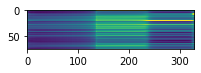

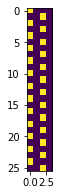

Count 400 | 할인되는 카드 있나요? _ => <s>ㅛ?</s> => 지금            


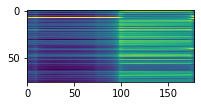

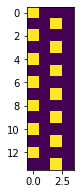

Count 600 | 음 통신사 할인같은건 없나요? ______ => <s>ㅛ?</s> => 아                      


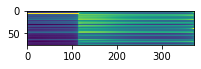

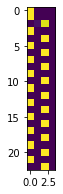

Count 800 | 안녕하세요 포장 예약을 하고 싶은데요 혹시 투움바 파스타도 포장이 가능한가요? ______ => <s>요?</s> => 아                                                 


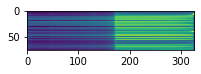

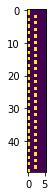

Count 808 | 라스터 오더가 몇시인가요? __ => <s>ㅛ?</s> => 오                


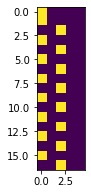

09-26 01:29:54
Mean Train Loss: 0.11751290062741475
Mean Train Seq2Seq Loss: 3.693163268158536
Train CER: 0.9862996248759104
Eval Count 50 | 예약하고 싶은데 어떻게 해야하죠? __ => <s>ㅛ?</s> => 오                    


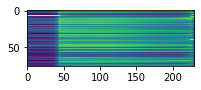

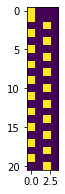

Eval Count 65 | 오늘 갈건데 차가지고 갈거라서요 주차공간 있나요? _____ => <s>ㅛ?</s> => 오                                


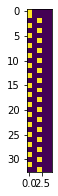

09-26 01:30:15
Mean Evaluation Loss: 0.08648922945907468
Mean Evaluation Seq2Seq Loss: 3.7466358368176516
Evaluation CER: 0.9958703843255463


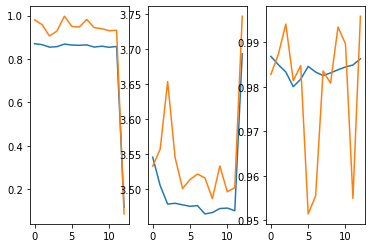

-------------------------------------------------------------------------------------------------------
09-26 01:30:15
Count 200 | 학생할인은 몇 살 부터 받을 수 있나요? _____ => <s>ㅇ요?</s> => 아기                          


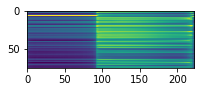

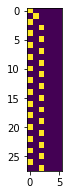

Count 400 | 지금 미리 메뉴 주문해놔도 될까요? __ => <s>ㅏ요?</s> => 지시                    


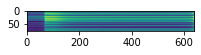

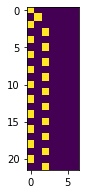

Count 600 | 주차 가능 시간이 있나요? ___ => <s>ㅇ나요?</s> => 아기                


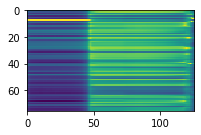

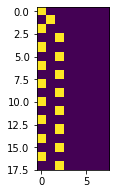

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>ㅇ나요?</s> => 아                                                 


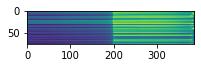

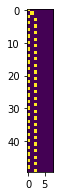

Count 808 | 베이비 백립도 배달 주문 가능한가요? _ => <s>나요?</s> => 아                     


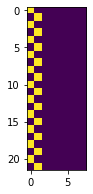

09-26 01:37:41
Mean Train Loss: 0.07798445724827767
Mean Train Seq2Seq Loss: 3.5730427695144655
Train CER: 0.9860855079293754
Eval Count 50 | 아침식사가 몇 시부터 가능할까요? __ => <s>나요?</s> => 아기                   


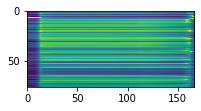

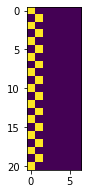

Eval Count 64 | 어린이 날에도 영업하나요? ___ => <s>나요?</s> => 아                 


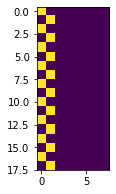

09-26 01:38:01
Mean Evaluation Loss: 0.08465458394583097
Mean Evaluation Seq2Seq Loss: 3.655871523190862
Evaluation CER: 0.9910105488457422


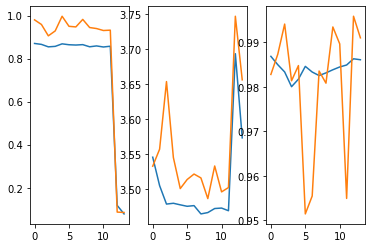

-------------------------------------------------------------------------------------------------------
09-26 01:38:02
Count 200 | 런치세트랑 일반 스테이크랑 어떻게 다른가요? ___ => <s>나요?</s> => 주                           


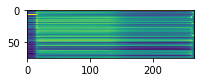

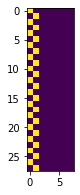

Count 400 | 단체는 몇일전에 예약해야 하나요? ___ => <s>나요?</s> => 아웃                    


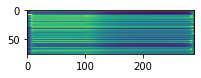

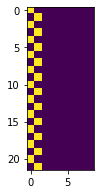

Count 600 | 각 자리마다 콘센트 있나요? __ => <s>ㅇㅆ나요?</s> => 아일                


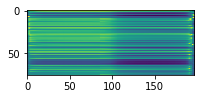

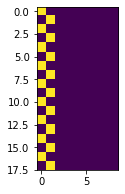

Count 800 | 다음주 월요일 4시에 10명 예약했는데 혹시 13명으로 인원 변경이 가능한가요? _____ => <s>ㅇㄴ나요?</s> => 주                                                 


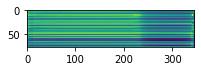

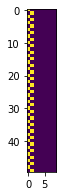

Count 808 | 네 핸드폰을 분실했는데 있을까요? ____ => <s>ㅇㄴ나요?</s> => 아                      


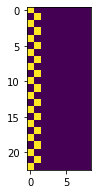

09-26 01:45:33
Mean Train Loss: 0.07610408009275943
Mean Train Seq2Seq Loss: 3.556953492788601
Train CER: 0.9867281739903753
Eval Count 50 | 오늘 투움바 파스타 다 팔렸나요? __ => <s>ㅇㄴ나요?</s> => 아                    


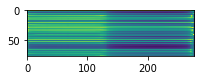

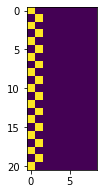

Eval Count 64 | 아웃백휴일이언제이지요? ____ => <s>ㅇㄴ나요?</s> => 아                


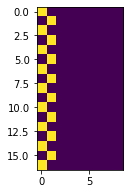

09-26 01:45:53
Mean Evaluation Loss: 0.08088730424284363
Mean Evaluation Seq2Seq Loss: 3.6791523885460826
Evaluation CER: 0.9934531059683313


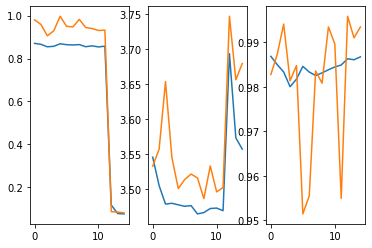

-------------------------------------------------------------------------------------------------------
09-26 01:45:54
Count 200 | 문 닫는 시간이 어떻게 되죠? ___ => <s>ㅇㄴ나요?</s> => 지기                  


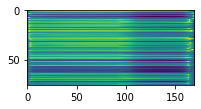

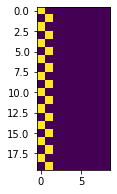

Count 400 | 20명에서 30명 정도인데 단체예약 가능한가요? __ => <s>인나요?</s> => 아금                           


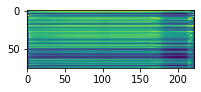

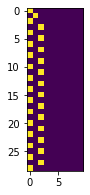

Count 600 | 라스트 오더가 몇 시인가요? _ => <s>아ㅣㄴ나요?</s> => 오일               


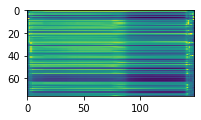

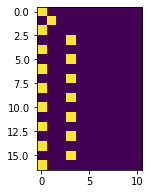

Count 800 | 오늘 블랙라벨 스테이크 다 팔렸나요? __ => <s>아ㅣㅆ나요?</s> => 아                      


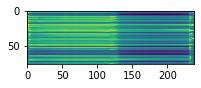

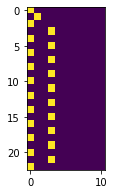

Count 808 | 제가 주차를 잘 못해서  서초점은 발레파킹이 안된다고 하는데 거기 지점은 되나요? ____ => <s>아ㅣㅆ나요?</s> => 아                                                 


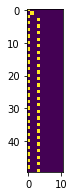

09-26 01:53:21
Mean Train Loss: 0.07400571384546616
Mean Train Seq2Seq Loss: 3.5402766032517845
Train CER: 0.9870043810404421
Eval Count 50 | 파스타 종류도 포장이 가능한가요? ___ => <s>아ㅣㅆ나요?</s> => 아                     


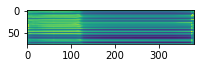

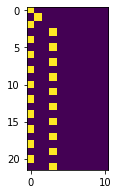

Eval Count 64 | 마감 시간이 몇시인가요? ___ => <s>있나요?</s> => 주                


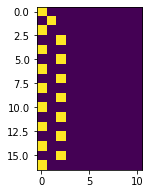

09-26 01:53:41
Mean Evaluation Loss: 0.07776175625864731
Mean Evaluation Seq2Seq Loss: 3.6993537066316056
Evaluation CER: 0.9934313137372526


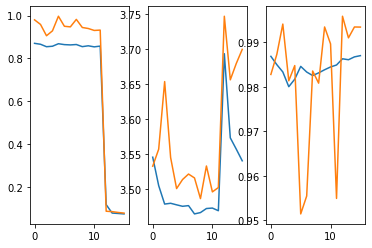

-------------------------------------------------------------------------------------------------------
09-26 01:53:41
Count 200 | 지금 가서 이용할 수 있는 자리가 남아있나요? _ => <s>아ㅣㄴ나요?</s> => 예약                         


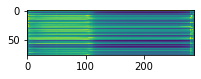

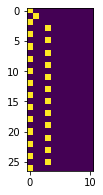

Count 400 | 저녁 7시 가능한가요? __ => <s>아요?</s> => 아웃             


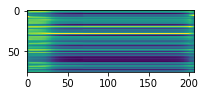

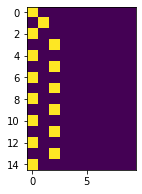

Count 600 | 보통 배달하면 시간 얼마나 걸려요? ___ => <s>ㅏ요?</s> => 아                      


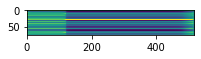

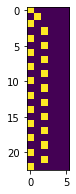

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>ㅏ요?</s> => 아                                                 


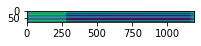

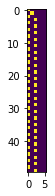

Count 808 | 네 혹시 얼마나 걸리나요? __ => <s>ㅏ요?</s> => 아                


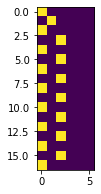

09-26 02:01:03
Mean Train Loss: 0.09068428369293101
Mean Train Seq2Seq Loss: 3.548513521762309
Train CER: 0.9836392596254188
Eval Count 50 | 통신사 할인 최대 금액이 얼마죠? __ => <s>ㅏ요?</s> => 아                    


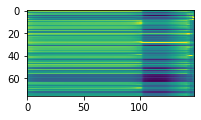

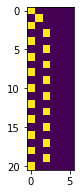

Eval Count 64 | 오늘 저 혼자 한 2시간 정도에 가려는데 예약 되나요?  => <s>ㅏ요?</s> => 아                              


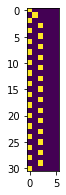

09-26 02:01:24
Mean Evaluation Loss: 0.15668370659165742
Mean Evaluation Seq2Seq Loss: 3.6978738466197685
Evaluation CER: 0.9931285120938187


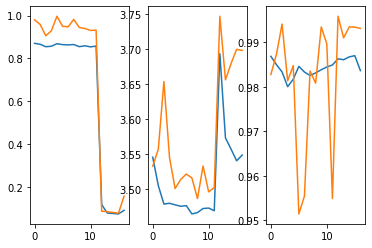

-------------------------------------------------------------------------------------------------------
09-26 02:01:25
Count 200 | 지금 대기 손님이 많아서 예약을 해야되나요? __ => <s>아ㅏ요?</s> => 아                          


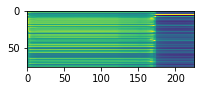

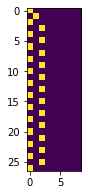

Count 400 | 2층에 단체석 예약 가능할까요? ____ => <s>아나요?</s> => 주차                    


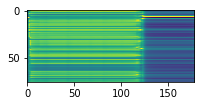

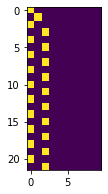

Count 600 | 스테이크 외 메뉴도 있나요? _ => <s>았나요?</s> => 아                


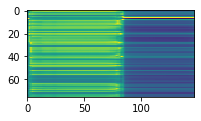

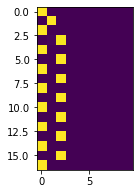

Count 800 | 아기 돌잔치를 할 장소를 찾고 있어요 아웃백에서 돌잔치 서비스를 제공하나요? _______ => <s>았나요?</s> => 아                                                 


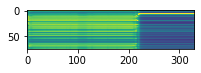

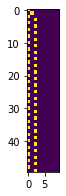

Count 808 | 점심에 가려고하는데 예약해야되나요? ___ => <s>았나요?</s> => 아                      


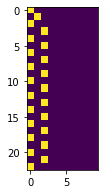

09-26 02:08:52
Mean Train Loss: 0.09135797127830292
Mean Train Seq2Seq Loss: 3.55434125738516
Train CER: 0.9851200169000696
Eval Count 50 | 어떤 방법으로 예약 가능할까요? ___ => <s>았나요?</s> => 아                    


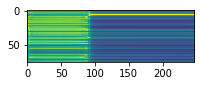

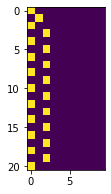

Eval Count 64 | 어린이용 메뉴는 없나요? ___ => <s>았나요?</s> => 아                


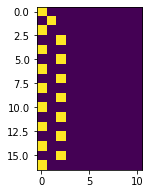

09-26 02:09:12
Mean Evaluation Loss: 0.07973440191617703
Mean Evaluation Seq2Seq Loss: 3.7041058766832
Evaluation CER: 0.9932137070889249


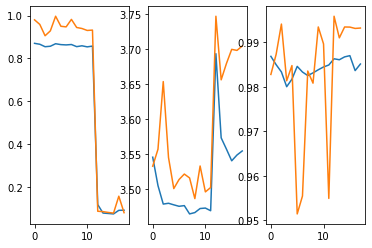

-------------------------------------------------------------------------------------------------------
09-26 02:09:13
Count 200 | 바로앞에 버스정류장이 있나요 __ => <s>아ㅣ나요?</s> => 아시                


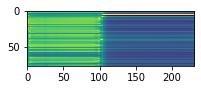

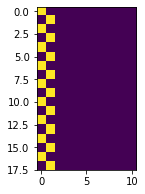

Count 400 | 어르신들이 드실 수 있는 연한 스테이크 있나요? __ => <s>아ㅣㄴ나요?</s> => 지일                           


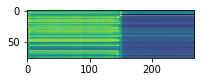

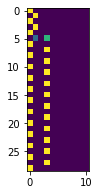

Count 600 | 오후 5시로 예약하고 싶어요 _ => <s>아ㅣㄴ나요?</s> => 아                


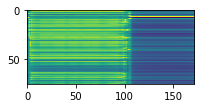

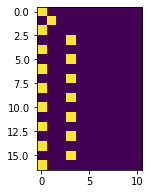

Count 800 | 오픈 시간과 마감시간을 알려주세요 ___ => <s>아ㅣㄴ나요?</s> => 주                     


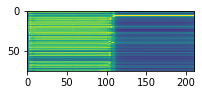

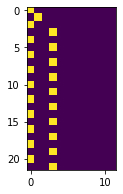

Count 808 | 금요일 오후 7시로 변경 해주시고 인원은 성인 4명 어린이 2명으로 변경 해주세요 _____ => <s>아ㅣㄴ나요?</s> => 예약                                                 


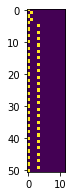

09-26 02:16:48
Mean Train Loss: 0.0734988954874704
Mean Train Seq2Seq Loss: 3.5417699027689014
Train CER: 0.985996175205353
Eval Count 50 | 겨울에만 특별히 따로 나오는 메뉴는 뭐가있나요? ___ => <s>아ㅣㄴ나요?</s> => 예약                            


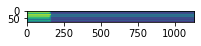

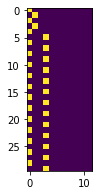

Eval Count 64 | 평일에는 몇 시부터 영업하세요? ____ => <s>아힌나요?</s> => 예약                    


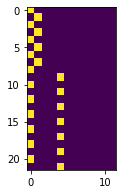

09-26 02:17:08
Mean Evaluation Loss: 0.07957845037205546
Mean Evaluation Seq2Seq Loss: 3.7070712631519314
Evaluation CER: 0.9788057445200302


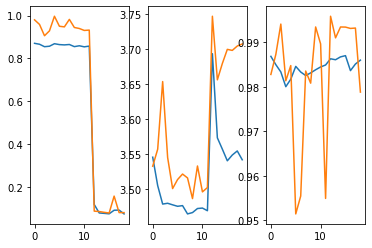

-------------------------------------------------------------------------------------------------------
09-26 02:17:09
Count 200 | 재고가 소진되지는 않았나요? ___ => <s>아ㅣㅆ나요?</s> => 주시                 


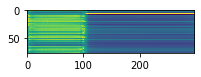

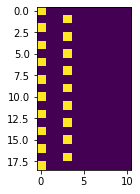

Count 400 | 오늘 식사가능한가요? ___ => <s>아있나요?</s> => 아약             


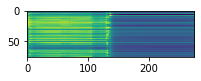

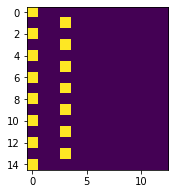

Count 600 | 세트메뉴에 있는 사이드 메뉴 다른걸로 선택 가능한가요? ___ => <s>앙있나요?</s> => 아                       요         


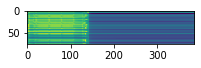

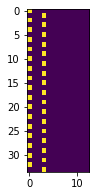

Count 800 | 세트 메뉴는 제휴 카드 할인이 안되나요?  => <s>앙있나요?</s> => 아                      


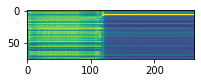

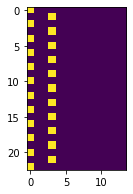

Count 808 | 내일 몇시까지 영업하나요? ___ => <s>앙있나요?</s> => 아기                


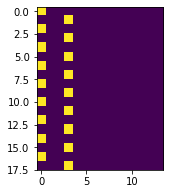

09-26 02:24:42
Mean Train Loss: 0.07178248277943508
Mean Train Seq2Seq Loss: 3.5483018614866855
Train CER: 0.9844154985453584
Eval Count 50 | 반포에서 센트럴 시티점 가는 길 좀 알려주세요 ____ => <s>앙있나요?</s> => 아기                            


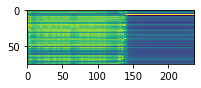

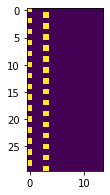

Eval Count 64 | 몇시까지 식사 가능할까요? ___ => <s>앙인나요?</s> => 아기                


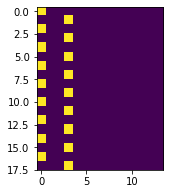

09-26 02:25:03
Mean Evaluation Loss: 0.07405294053463808
Mean Evaluation Seq2Seq Loss: 3.6750114937132334
Evaluation CER: 0.9891424972256381


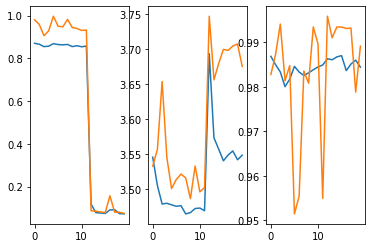

-------------------------------------------------------------------------------------------------------
09-26 02:25:04
Count 200 | 지금 가면 어느정도 기다릴까요? ____ => <s>아있나요?</s> => 아                     


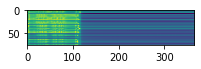

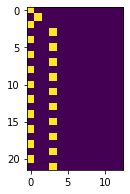

Count 400 | 지금 5명 자리 있나요? _ => <s>아ㅏ있나요?</s> => 아약             


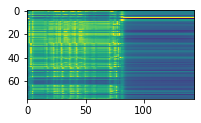

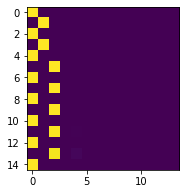

Count 600 | 영업시간이 인터넷에 나와있는시간이랑  왜 다른거죠~? ___ => <s>아ㅏㅅ아ㅣㅏㅏㅏㅣㅏㅏㅏ이나요?</s> => 아일                               


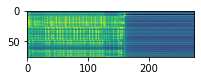

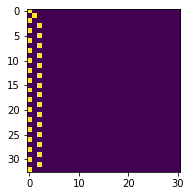

Count 800 | 공휴일에 런치메뉴 주문가능한가요? ____ => <s>아이ㅣ이잉ㅇ이앗아가으이나요?</s> => 아                      


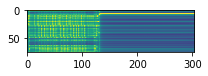

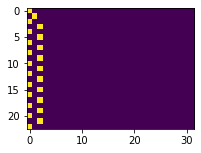

Count 808 | 영업시간이 어떻게 되나요? __ => <s>아ㅣㅣ가인나요?</s> => 주          ? ? ? 


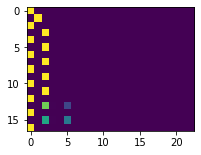

09-26 02:32:47
Mean Train Loss: 0.06622863846760203
Mean Train Seq2Seq Loss: 3.538161115714658
Train CER: 0.9841100321491121
Eval Count 50 | 단체할인은 몇%에요? ___ => <s>아ㅣ아ㅣ아가ㅏ있나요?</s> => 주기             


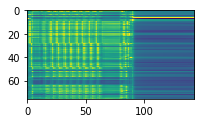

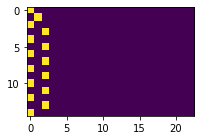

Eval Count 64 | 식사하면 몇시간까지 주차되나요? ___ => <s>아ㅏㅇ아아시ㅏㅏ가지가ㅏㅏ한나요?</s> => 주업                   


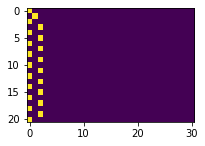

09-26 02:33:10
Mean Evaluation Loss: 0.0672081140577577
Mean Evaluation Seq2Seq Loss: 3.557484737433683
Evaluation CER: 0.96883904213398


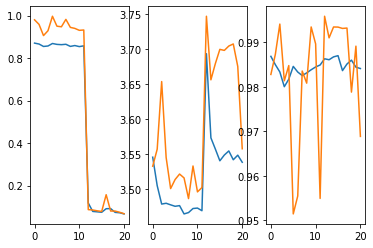

-------------------------------------------------------------------------------------------------------
09-26 02:33:10
Count 200 | 멤버십 정립을 하면 할인이 불가능한가요? _____ => <s>아으으시아이아ㅏㅡ가으ㅣㅈ가한나요?</s> => 아금                   ?      


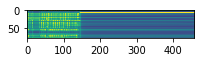

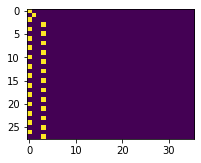

Count 400 | 금요일 저녁에 예약 아직 되나요? ___ => <s>아이으이가가으하나요?</s> => 아금                    


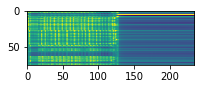

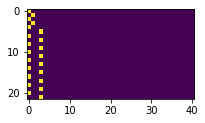

Count 600 | 주차장은 어디로 가면 되죠? _ => <s>아으아ㅡ가지아가읒있나요?</s> => 아기               


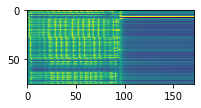

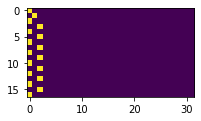

Count 800 | 안녕하세요 포장 예약을 하고 싶은데요 혹시 투움바 파스타도 포장이 가능한가요? ______ => <s>아으ㅏ이아ㅏㅏ이아아시이시시이잇가ㅡ아가ㅏㅇㅇ가아ㅣㅏ한가요?</s> => 안녕                                                


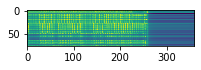

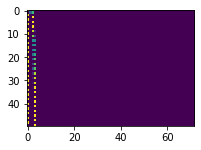

Count 808 | 제가 갈건 아닌데 예약 가능한가요? ______ => <s>앙아가이이이이아가하나요?</s> => 아                         


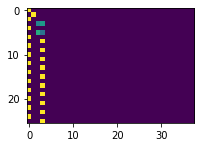

09-26 02:41:21
Mean Train Loss: 0.06207122312923803
Mean Train Seq2Seq Loss: 3.466227018726306
Train CER: 0.9690935376798654
Eval Count 50 | 미리 주문해놔도 되나요? __ => <s>아ㅣ차아이아이나요?</s> => 단차              


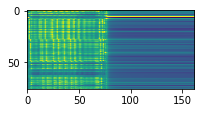

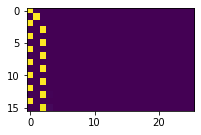

Eval Count 64 | 아 네 안녕하세요 네 반갑습니다 _____ => <s>앙이강아ㅏ이이가이나요?</s> => 주                      


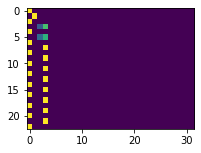

09-26 02:41:43
Mean Evaluation Loss: 0.06429785286836628
Mean Evaluation Seq2Seq Loss: 3.5191134038553695
Evaluation CER: 0.9745688217998848


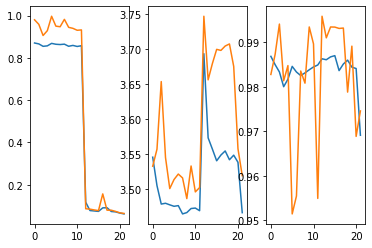

-------------------------------------------------------------------------------------------------------
09-26 02:41:43
Count 200 | 케이크 가지고 방문해도 될까요? _ => <s>아ㅏ가시ㅏㅏㅏ이나요?</s> => 주                ? 


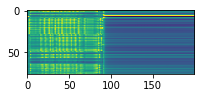

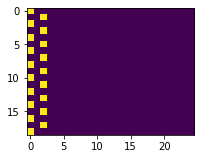

Count 400 | 아기랑 같이 갈건데 혹시 조용한 자리 있나요? ___ => <s>아잉ㅇ가시가ㅣ가이나요?</s> => 아일                           


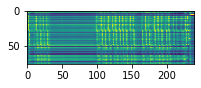

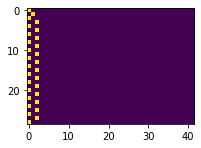

Count 600 | 식판 받침대 분리 되나요? ___ => <s>아가갓사이나요?</s> => 주기        요요      


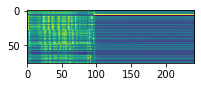

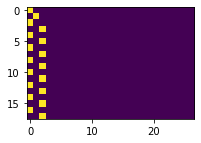

Count 800 | 이번달에 영업하지 않는 날이 있나요 ____ => <s>아ㅔ이ㅏ아아ㅣ으이인나요?</s> => 주기                      


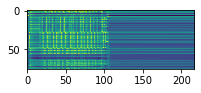

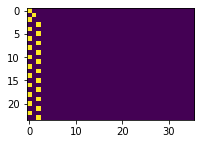

Count 808 | 안녕하세요 1월 31일 오후에 예약을 했던 사람인데 혹시 시간대 변경 가능한가요? ___ => <s>아ㅏ악시엥시지에에ㅏ이이가잊아아이ㅣㅇ아시시가에ㅏ시강한가요?</s> => 아녕 세요                                            


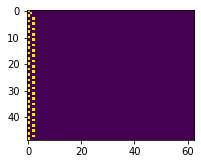

09-26 02:50:01
Mean Train Loss: 0.060962867894812055
Mean Train Seq2Seq Loss: 3.4153627067345735
Train CER: 0.9580466818381548
Eval Count 50 | 오늘 저녁 7시에 성인 4명 아이 2명 예약 되나요?  => <s>ㅇ이어아이ㅏㅣㅏ이ㅣㅇㅇ이에ㅏ이나요?</s> => 아                             


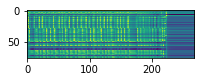

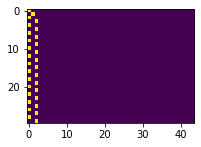

Eval Count 64 | 음료수나 와인이 제공되나요? __ => <s>아시ㅏ가ㅏㅇㅇ이에인나요?</s> => 아           요     


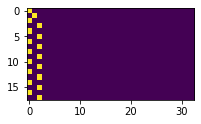

09-26 02:50:22
Mean Evaluation Loss: 0.06782328559231547
Mean Evaluation Seq2Seq Loss: 3.5327451688780793
Evaluation CER: 0.9733492442322991


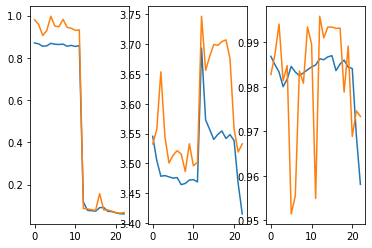

-------------------------------------------------------------------------------------------------------
09-26 02:50:23
Count 200 | 예약 당일 취소 가능한가요? ____ => <s>아가에시시가가한가요?</s> => 지           가       


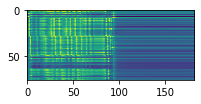

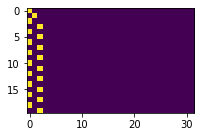

Count 400 | 지금 예약 가능한가요? __ => <s>아으아이아앙한나요?</s> => 생일       가나요?  


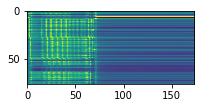

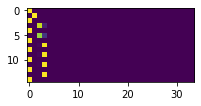

Count 600 | 20명 정도 단체 모임을 하려고 하는데 예약 가능한가요? _ => <s>아사하ㅡ가수이ㅏ가고ㅡㅇ한가요?</s> => 단녕하세요                    가 요? ?  


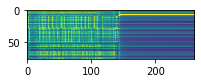

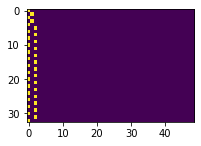

Count 800 | 평일 오픈시간을 알 수 있을까요? ____ => <s>아이타시아아 있나요?</s> => 아웃          요요     요?  


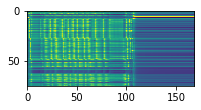

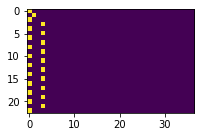

Count 808 | 저희 3명이 가려고 하는데요 _ => <s>아사이아타아가 이네요?</s> => 런시         요요    


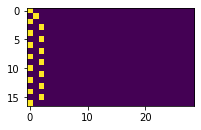

09-26 02:58:42
Mean Train Loss: 0.05922824379188504
Mean Train Seq2Seq Loss: 3.3418410919991843
Train CER: 0.9283787119983071
Eval Count 50 | 런치 메뉴에 디저트도 포함인가요? ___ => <s>아치임으이치시가아으가 한나요?</s> => s치             가요요요?  


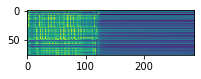

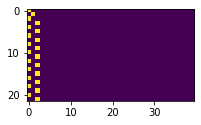

Eval Count 64 | 아이가 있어서 자가용타고 갈껀데 주차공간이 있나요? __ => <s>아ㅣ에사아사ㅏ가ㅏ강차차이아있나요?</s> => 아                              


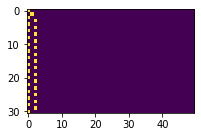

09-26 02:59:04
Mean Evaluation Loss: 0.05985877452491515
Mean Evaluation Seq2Seq Loss: 3.4626845650062483
Evaluation CER: 0.9147839635644514


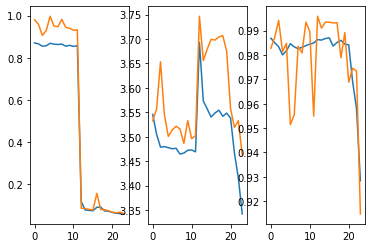

-------------------------------------------------------------------------------------------------------
09-26 02:59:05
Count 200 | 쿠폰에 요금 추가 하면 메뉴 변경 가능해요? __ => <s>아차이옂시가이에엥자오가으네요?</s> => 아치                  요요요    


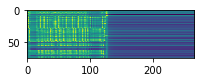

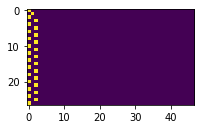

Count 400 | 오늘 예약 가능할까요? __ => <s>앙있나요?</s> => 아일             


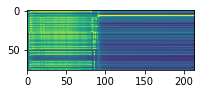

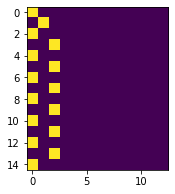

Count 600 | 월요일아침마다 배달 받을 수 있나요? ____ => <s>아있나요?</s> => 아                        


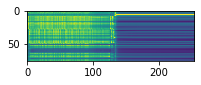

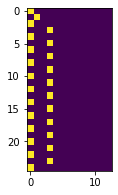

Count 800 | 차타고 가고 있는데 신세계백화점 맞은편 대로에서 어느 골목으로 들어가야하나요? ______ => <s>아ㅏ아ㅏㅇ이아아아ㅏㅇ아아가ㅡㅏㅏ가ㅏㅏ한가요?</s> => 아웃                                           ? ? ?


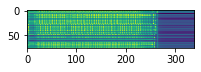

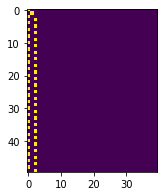

Count 808 | 어린이날에 영업 하시나요? __ => <s>아아아ㅏㅏ이나요?</s> => 아          나요    


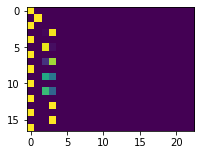

09-26 03:06:50
Mean Train Loss: 0.06610086527606404
Mean Train Seq2Seq Loss: 3.4602170282909737
Train CER: 0.9581716635980543
Eval Count 50 | 스테이크는 얼만가여? ___ => <s>아ㅏ한가요?</s> => 주         능요요  


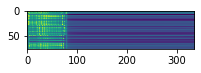

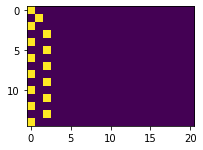

Eval Count 64 | 보통 몇 시에 영업시작하시나요? ____ => <s>아ㅏ시아시아안가요?</s> => 주          가       ?  


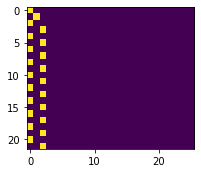

09-26 03:07:12
Mean Evaluation Loss: 0.06921221295572513
Mean Evaluation Seq2Seq Loss: 3.6051277531815735
Evaluation CER: 0.9036016304678469


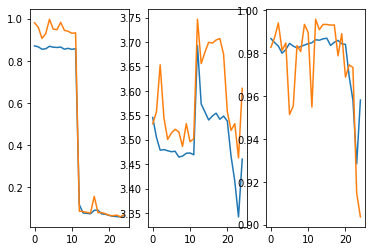

-------------------------------------------------------------------------------------------------------
09-26 03:07:13
Count 200 | 몇명부터 단체 할인이 되나요? _ => <s>아가ㅏ사이나요?</s> => 주       요         


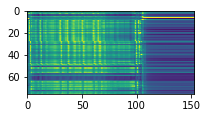

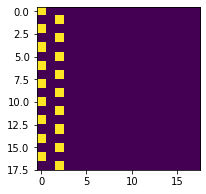

Count 400 | 10명 정도 가는데 예약 안 하면 자리 없을까요? ___ => <s>아이ㅣ이여싱이아잉아어갓ㅇ이나요?</s> => 아일                             


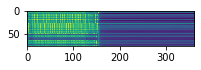

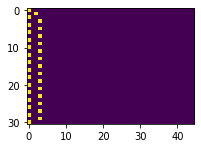

Count 600 | 저희 3명이 가려고 하는데요 __ => <s>아아시가아 이나요?</s> => 오         요요요?    


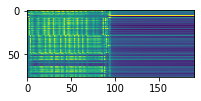

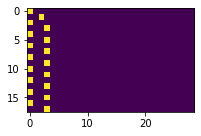

Count 800 | 아웃백마지막주문이언제까지인가요? ______ => <s>아ㅏ으아시아에이에에가 이나요?</s> => 아               있나요?    


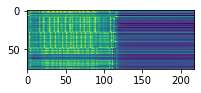

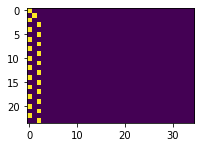

Count 808 | 전화로만 예약이 가능한가요? 앱으로도 예약할 수 있나요? 예약 방법 알려주세요 ______ => <s>아ㅏ이이ㅏ이읒아가ㅣ가이나요?</s> => 아웃                                                


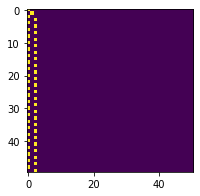

09-26 03:15:27
Mean Train Loss: 0.06101823303244483
Mean Train Seq2Seq Loss: 3.3766922374125303
Train CER: 0.9284683828800894
Eval Count 50 | 오늘 시저샐러드 다 팔린 건가요? __ => <s>아엥시아가으가강인나요?</s> => 아          요요?   요?? 


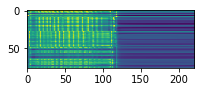

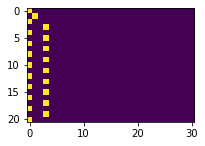

Eval Count 64 | 세트메뉴 주문할 수 있어요? _ => <s>아가으으시오아시 이나요?</s> => 주          있요요?  


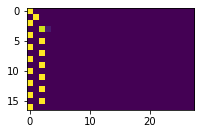

09-26 03:15:48
Mean Evaluation Loss: 0.061628332758843135
Mean Evaluation Seq2Seq Loss: 3.513889340804454
Evaluation CER: 0.8782254138266796


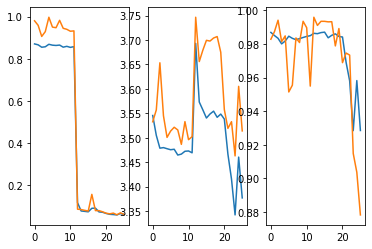

-------------------------------------------------------------------------------------------------------
09-26 03:15:49
Count 200 | 오늘 두시 예약하고 싶은데 룸 자리 있나요? ___ => <s>아지시이야가시가아이이아 가 있나요?</s> => 아일                          


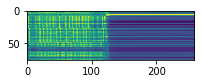

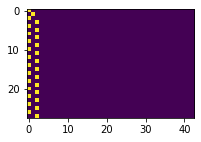

Count 400 | 아웃백 서울대점 주차공간있나요? ___ => <s>아ㅏ사이에아시으아 이나요?</s> => 아일                   


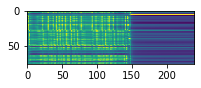

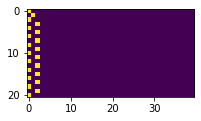

Count 600 | 주차공간이 어떻게 되나요? __ => <s>자시차가에강 이나요?</s> => 몇시         요요    


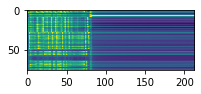

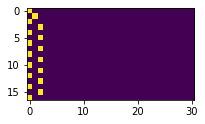

Count 800 | 아웃백에서 학생 할인이 되는지 궁금합니다 무엇을 어떻게 물어보실 건가요? _________ => <s>아치ㅏ하ㅣ가이이메지ㅡㅔ마아압브브시가주 디나요?</s> => 아웃                                                


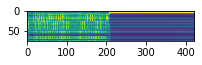

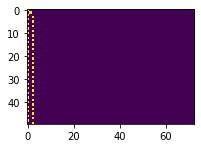

Count 808 | 매장 이용시 얼마나 주차할 수 있나요? _ => <s>아아이시마노ㅗ수시ㅏ주 있나요?</s> => 오기               나요?   


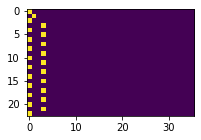

09-26 03:24:14
Mean Train Loss: 0.056756813532813595
Mean Train Seq2Seq Loss: 3.279499068061243
Train CER: 0.8969875133722663
Eval Count 50 | 얼마나 기다려야지 식사 가능할까요? ___ => <s>아ㅏ아가시ㅏ에지시아가능한가요?</s> => 오약             능한능요?   


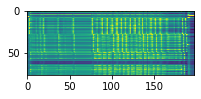

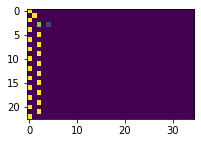

Eval Count 64 | 점심 시간은 어떻게 되요? __ => <s>아시시가나가이세요?</s> => 오시          요?   


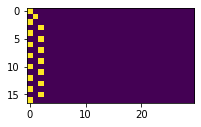

09-26 03:24:36
Mean Evaluation Loss: 0.05922585714589637
Mean Evaluation Seq2Seq Loss: 3.5013193062789227
Evaluation CER: 0.8817050537012809


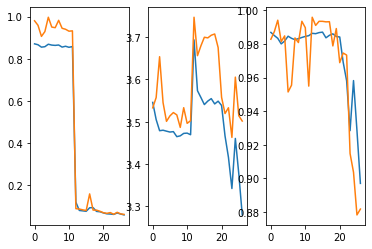

-------------------------------------------------------------------------------------------------------
09-26 03:24:36
Count 200 | 몇시에 마감인가요? __ => <s>아시오가강한가요?</s> => 몇시    능가요?   


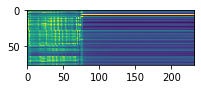

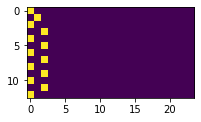

Count 400 | 몇 시부터 몇 시까지 영업하나요? ___ => <s>아시ㅡ토시가이 한가요?</s> => 혹시             요요?    


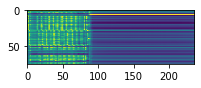

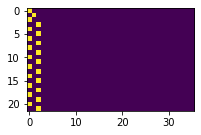

Count 600 | 대중교통으로 가는 게 낫나요 아니면 차로 가는 게 낫나요 __ => <s>아앙아용?</s> => 아기                         요요?    


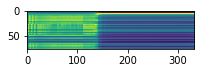

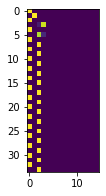

Count 800 | 거기 근처에 8번 버스 서나요?  => <s>아아앙ㅇㅇ아요?</s> => 아           요     


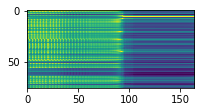

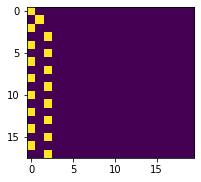

Count 808 | 주말 저녁에 예약하고 싶은데 될까요? __ => <s>아아     ㅇ  ㅇㅇ아요?</s> => 아                      


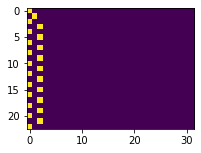

09-26 03:32:38
Mean Train Loss: 0.06496760666395943
Mean Train Seq2Seq Loss: 3.3724971775518227
Train CER: 0.9199311055095745
Eval Count 50 | 오늘 투움바 파스타 다 팔렸나요? ___ => <s>아    ㅏ요?</s> => 아                     


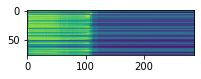

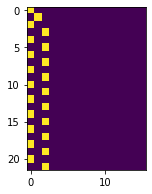

Eval Count 64 | 학생할인은 몇%인가요? ____ => <s>앙 ㅏ요?</s> => 아                


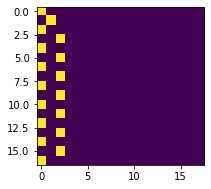

09-26 03:32:59
Mean Evaluation Loss: 0.0906728564978185
Mean Evaluation Seq2Seq Loss: 3.697341028391792
Evaluation CER: 0.9910570078363343


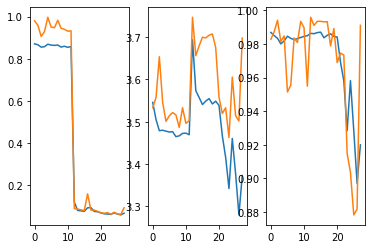

-------------------------------------------------------------------------------------------------------
09-26 03:33:00
Count 200 | 휴일에는 영업시간 중 언제가 복잡하나요? _____ => <s>아ㅏ요?</s> => 주시                  요요요     


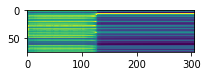

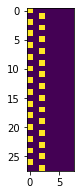

Count 400 | 혹시 주차비 따로 받나요?  => <s>아ㅏ요?</s> => 아일             


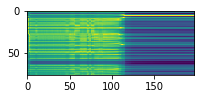

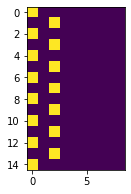

Count 600 | 런치세트 종류에는 어떤 것이 있나요 _____ => <s>안요?</s> => 아                        


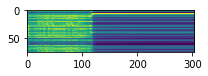

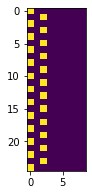

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>아가ㅏㅏ갓ㅅ가ㅏ사ㅏㅣㅏ요?</s> => 주                                                 


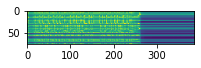

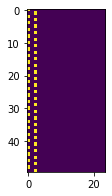

Count 808 | 할인 되는 쿠폰 있나요? ____ => <s>아가가ㅣ나요?</s> => 아          요 ?   요


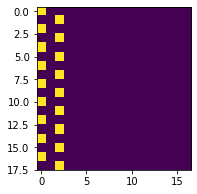

09-26 03:40:30
Mean Train Loss: 0.07272754380638449
Mean Train Seq2Seq Loss: 3.5004962455985735
Train CER: 0.9558869991048391
Eval Count 50 | 1월 26일 저녁 7시요 _ => <s>아ㅏ요?</s> => 아          요 ? 


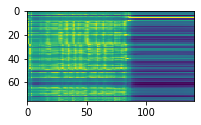

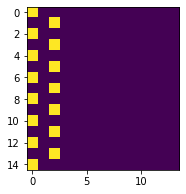

Eval Count 64 | 네 며칠전에 예약을 했는데 확인차 연락드렸어요 _______ => <s>아시ㅏㅏㅏ요?</s> => 안금                 ?             


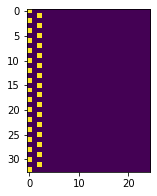

09-26 03:40:51
Mean Evaluation Loss: 0.06739390063862302
Mean Evaluation Seq2Seq Loss: 3.621681938788072
Evaluation CER: 0.9259971901533199


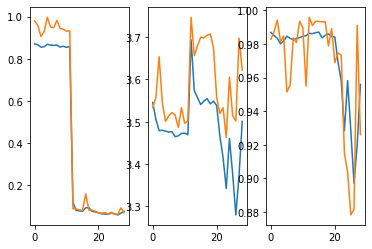

-------------------------------------------------------------------------------------------------------
09-26 03:40:52
Count 200 | 네 스테이크와 샐러드 음료 포장 부탁드립니다 __ => <s>앋ㅅ가가ㅏ그느갇ㄷ다이요?</s> => 아기                         


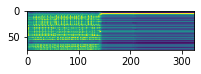

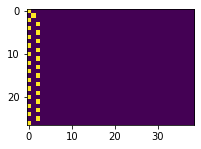

Count 400 | 할인 쿠폰이 있나요? ___ => <s>이가가이나요?</s> => 할인       나요    


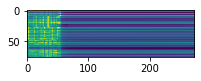

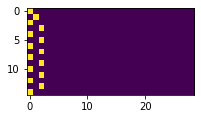

Count 600 | 크리스마스에 가려면 예약 해야 하나요? _ => <s>아차맛이에ㅏ느므야드에하하ㅏ요?</s> => 단                      


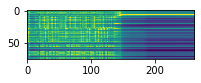

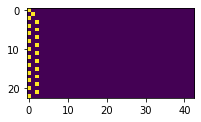

Count 800 | skt 할인 행사는 포인트가 남아있어야만 가능한건가요? 자세하게 알 수 있을까요? ____ => <s>ㅇㅅ체ㅡㅏㅣ에상가느자가가시사가자나가가다ㅏ요?</s> => 혹                                                 


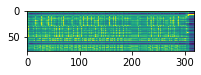

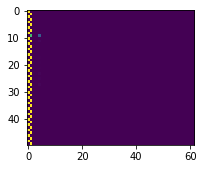

Count 808 | 아기 놀이방이 운영되나요? __ => <s>아지므이가느이으다으에아ㅏ요?</s> => 아기          요   나


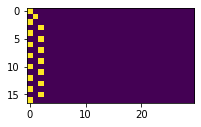

09-26 03:49:07
Mean Train Loss: 0.05800593919019017
Mean Train Seq2Seq Loss: 3.2607340162969485
Train CER: 0.8856491295972133
Eval Count 50 | 9시에 주문해도 식사 할 수 있나요? _ => <s>아시에지므도시ㅏ시이이나요?</s> => 몇시              나있요?? 


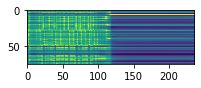

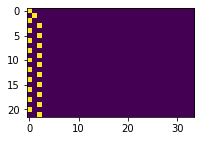

Eval Count 64 | 추석 연휴에 영업하나요? ___ => <s>자ㅏ이잉야야하ㅏ요?</s> => 예일 예약    하나요요?   


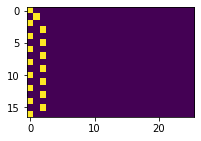

09-26 03:49:29
Mean Evaluation Loss: 0.05809270945944728
Mean Evaluation Seq2Seq Loss: 3.445650971193563
Evaluation CER: 0.8526190184799902


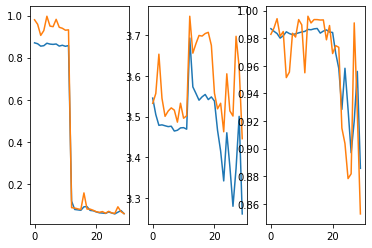

-------------------------------------------------------------------------------------------------------
09-26 03:49:29
Count 200 | 지인한테 전달받은 쿠폰도 사용가능한가요? _____ => <s>자이므드ㅏ마나데아간다다아가느하가요?</s> => 생일               가능가가 ?     


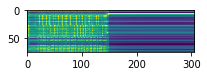

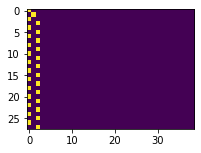

Count 400 | 금요일 저녁에 예약 아직 되나요? __ => <s>아으여이가여에이야가이드나요?</s> => 아기            나요요요?  


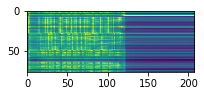

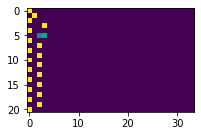

Count 600 | 할인카드는 무엇있나요? ____ => <s>자이타에드또어시이나요?</s> => 아차         나요?   


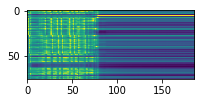

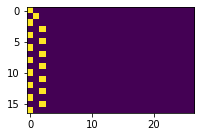

Count 800 | 제가 친구들과 아웃백에 가려고 하는데요 아기들이 있어서요 같이 식사 가능한가요? _____ => <s>주가아치마에가가데아이봉이뎅가지지이시제아주이지시아아 가니아나요?</s> => 주차                                        요?    ??


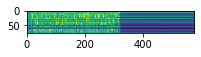

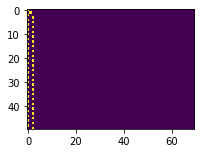

Count 808 | 토요일이요 주말도 예약가능한거죠? ____ => <s>이이잉마이도잉가느느가요?</s> => 생일일 일             요요   


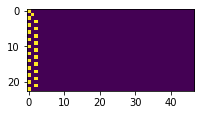

09-26 03:57:55
Mean Train Loss: 0.05317717395345577
Mean Train Seq2Seq Loss: 3.1245675885629747
Train CER: 0.8591213586378538
Eval Count 50 | 파스타도 배달해 주나요? _ => <s>이시타도디마이시나요?</s> => 몇치         요요? 


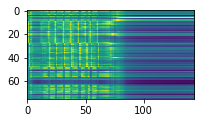

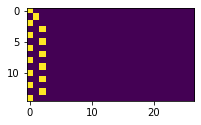

Eval Count 64 | 생일 축하 쿠폰이 있는데 생일 지나도 쓸 수 있죠? __ => <s>아스가호고응여ㅡㅇ조오여더시ㅏㅛ?</s> => 안장                             


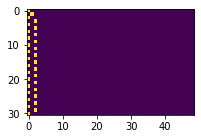

09-26 03:58:17
Mean Evaluation Loss: 0.05975011507850991
Mean Evaluation Seq2Seq Loss: 3.496590270786311
Evaluation CER: 0.89372591522158


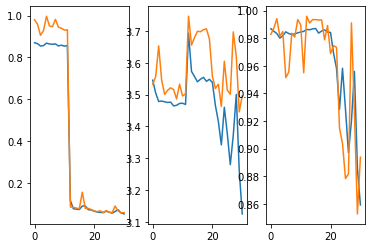

-------------------------------------------------------------------------------------------------------
09-26 03:58:17
Count 200 | 통신사 할인은 몇퍼센트죠? ____ => <s>아지자이며이며가에ㅣ죠?</s> => 아웃           요요    


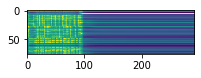

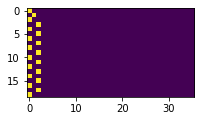

Count 400 | 1시간뒤에 자리 있나요? _ => <s>아치아징ㅇ타있나요?</s> => 단체      있나요?   


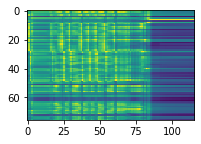

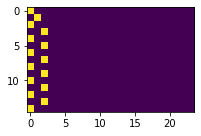

Count 600 | 요즘 사람들이 제일 많이 주문하는 메뉴는 무엇인가요? ____ => <s>여체 장데이 ㅊ에가느시므으메으으모하시나요?</s> => 오늘                         나요? ?  


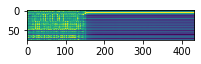

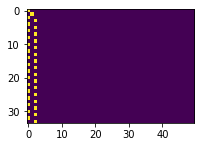

Count 800 | 아웃백 매장 오픈 시간이 언제인가요? __ => <s>아메메차므트시므아ㅏ충나요?</s> => 아웃               나요요   


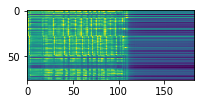

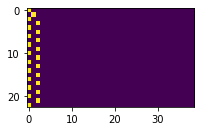

Count 808 | 주말에 몇 시 오픈인가요? ___ => <s>주마에뎣 시에오도이나요?</s> => 주말에 몇시시   나나요?    


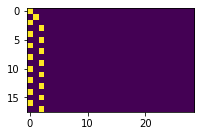

09-26 04:06:41
Mean Train Loss: 0.050402085840155694
Mean Train Seq2Seq Loss: 3.0290318698975063
Train CER: 0.8393291072371897
Eval Count 50 | 배달 가능한 스테이크가 있을까요? _ => <s>오메가아 수가 가아이시가요?</s> => 매장                요 


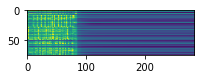

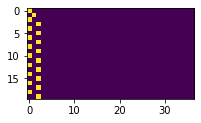

Eval Count 64 | 보통 몇시에 오픈하나요 ? __ => <s>잧며 시야포뎓나요?</s> => 주금 몇 시   하나요요?   


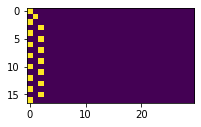

09-26 04:07:03
Mean Evaluation Loss: 0.05046212274808651
Mean Evaluation Seq2Seq Loss: 3.267877049058405
Evaluation CER: 0.8480322784619554


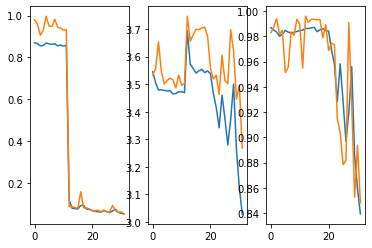

-------------------------------------------------------------------------------------------------------
09-26 04:07:03
Count 200 | 여친앞에서 잘보이고 싶은데 발레파킹 되나요? ___ => <s>자치마서자느이시간데ㅏ느보다죄나요?</s> => 주금                 나요       


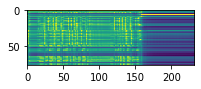

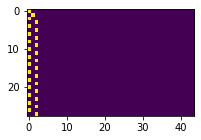

Count 400 | 혹시 노키즈존인가요? ___ => <s>아시모체이이있나요?</s> => 단체     있있요요?   


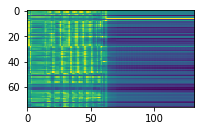

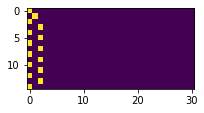

Count 600 | 생일 기념으로 서비스 제공해주시나요? __ => <s>여이치며ㅗ어저으 시체고여두싰나요?</s> => 오일               나요    


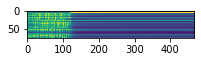

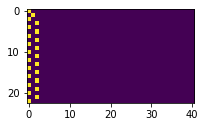

Count 800 | 예약 안했는데 급하게 식사를 해야할 일이 생겨서요 대기시간이 얼마나 될까요? _______ => <s>에약가니믄데트까이식수앵야이시드ㅏㄹ체이시가져아마ㅏ데까요?</s> => 예약                                                


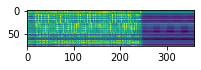

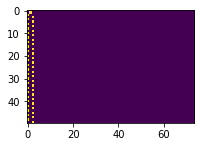

Count 808 | 런치메뉴는 몇시까지이죠? ____ => <s>안치가이오마지가지죠?</s> => 런치        죠?죠?    


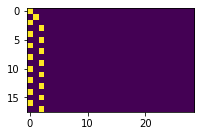

09-26 04:15:28
Mean Train Loss: 0.04732103766261695
Mean Train Seq2Seq Loss: 2.9371346553336077
Train CER: 0.8194167412545275
Eval Count 50 | 버스정류장에서 어떻게 가면 되는 지 궁금합니다 ____ => <s>앗아으아하상어 츠 하는체는제가느하다.</s> => 안녕하세요                         


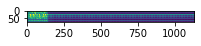

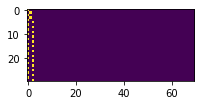

Eval Count 64 | 4명 저녁 예약하고 싶어서요 _ => <s>오여지마예야하으지하나요?</s> => 오0     약 하 하요?   


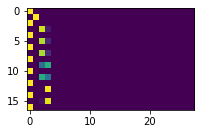

09-26 04:15:50
Mean Evaluation Loss: 0.04867188397429531
Mean Evaluation Seq2Seq Loss: 3.2210154795370425
Evaluation CER: 0.8288880879437737


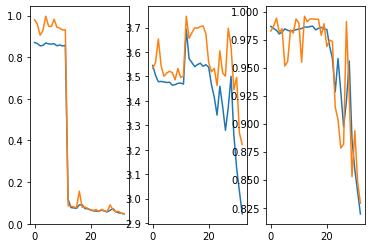

-------------------------------------------------------------------------------------------------------
09-26 04:15:50
Count 200 | 지금 방문하려고 하는데 영업 중이신가요? ____ => <s>지가 가ㅗ아녀 거ㅡㄴ예여억수으이나요?</s> => 지금 가               있나요?    


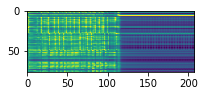

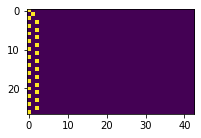

Count 400 | 예약은 어떻게 하나요? __ => <s>예야그ㅏ토졍가가요?</s> => 예약은     하하나요   


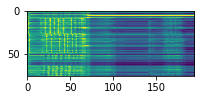

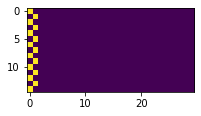

Count 600 | 아기를 눕혀야 하는데 소파석 있나요? __ => <s>아이에느다 할르데 소버거이 이나요?</s> => 아린               나요?   


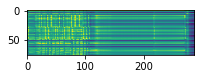

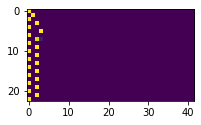

Count 800 | 단체라 인원이 많은데 다음주 일요일 오후 5시에 20명 룸으로 예약 가능할까요? ____ => <s>안체가이아이가느드카 지즈ㅡ으오오사소시ㅣ에에치모녕으노ㅗ이약가능하까요?</s> => 아체                                     능까요까요??? ?


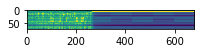

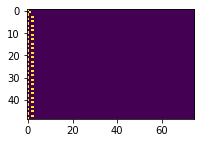

Count 808 | 다시 한번 말해주시겠어요? __ => <s>하치하만마에지시 이ㅔ요?</s> => 단시        있있요요   


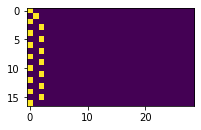

09-26 04:24:16
Mean Train Loss: 0.0454601616821564
Mean Train Seq2Seq Loss: 2.855589614254902
Train CER: 0.8038812249526747
Eval Count 50 | 추석에 5명정도 예약하고 싶은데 가능한가요? ___ => <s>주사데에 가사며조몬예약 가노 숲껀데 가능 하가요?</s> => 죄송한                         


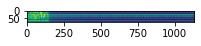

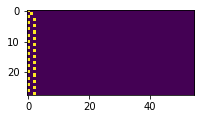

Eval Count 64 | 라스트 오더가 몇 시인가요? _ => <s>모시체더하유 시있나요?</s> => 혹시 메뉴      있     


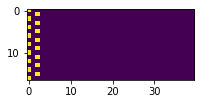

09-26 04:24:38
Mean Evaluation Loss: 0.04703554666789207
Mean Evaluation Seq2Seq Loss: 3.1174951019923878
Evaluation CER: 0.8063445795088068


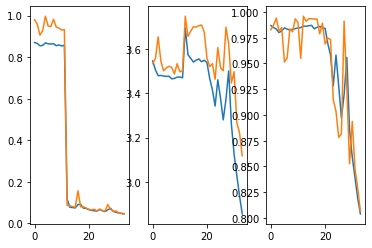

-------------------------------------------------------------------------------------------------------
09-26 04:24:39
Count 200 | 학생 할인 받을 때 학생증이 필요한가요? ____ => <s>잣하인마인데야으므이데여하가요?</s> => 단체 할인              가 가요?   


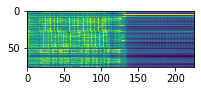

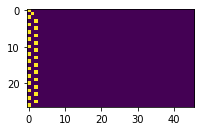

Count 400 | 브레이크 타임이 있나요?  => <s>이차그자하있나요?</s> => 유료 자   있있있나?  


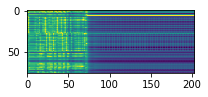

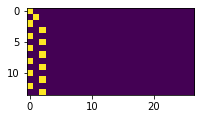

Count 600 | 얼마 이상 결제해야 주차가 가능한가요? _ => <s>아이바이가저체옝약이차가 가능한가요?</s> => 아체  돌       약 가능가요요?   


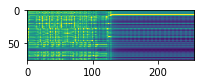

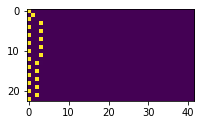

Count 800 | 안녕하세요 이번주 일요일에 저희 아이가 생일인데 생일 파티 예약가능한가요? ________ => <s>아느하뎅간지잉 가하여하가시이이데애으 가이야 가능한가요?</s> => 안녕하세요                            가 능가가요가요?        


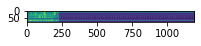

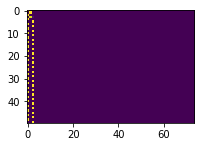

Count 808 | 지금 전화예약 가능한가요? __ => <s>지브타마이약가능한가요?</s> => 지금     약 능능가가요?  


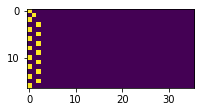

09-26 04:33:11
Mean Train Loss: 0.04284968537827752
Mean Train Seq2Seq Loss: 2.765894801918253
Train CER: 0.7868807993665266
Eval Count 50 | 몇명부터 단체 인가요? __ => <s>여명우터산테이가요?</s> => 영업 시       가요? 


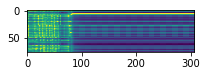

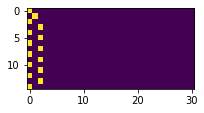

Eval Count 64 | 런치타임에도 예약을 받으시나요? ____ => <s>오ㅣ치가이느슨예약이뜨ㅐ 시나요?</s> => 런치               요요?  


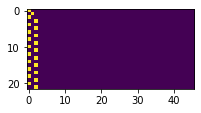

09-26 04:33:33
Mean Evaluation Loss: 0.04358313414851262
Mean Evaluation Seq2Seq Loss: 3.0273444831062015
Evaluation CER: 0.7820737605804111


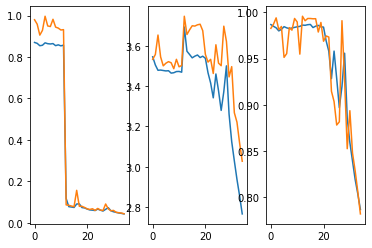

-------------------------------------------------------------------------------------------------------
09-26 04:33:33
Count 200 | 단체할인 같은 것도 있나요? ____ => <s>다게아인마그 가드이 있나요?</s> => 할체할할인               


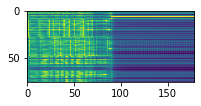

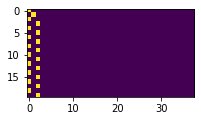

Count 400 | 어르신들이 드실 수 있는 연한 스테이크 있나요? __ => <s>어일신즈 제늣시이느여어아 구테이 그리있나요?</s> => 어일                 어  있나요?   


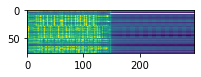

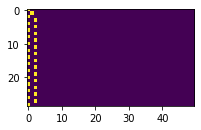

Count 600 | 상봉역에서 얼마나 걸려요? __ => <s>자므영으아마아가뢰ㅔ요?</s> => 주문    얼 얼마나나요요   


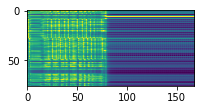

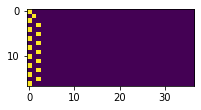

Count 800 | 브레이크 타임은 몇시부터 몇시까지에요? ___ => <s>자리크가이만 몇시끄턴몇시까징요?</s> => 런레 크   는부터 몇 몇시까지지인요?    


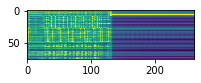

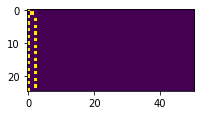

Count 808 | 예약 안했는데 급하게 식사를 해야할 일이 생겨서요 대기시간이 얼마나 될까요? _______ => <s>예야 하으는뎅 코텅 수사으하느아에이사매소ㅛ매 사하녀하가르될까요?</s> => 예약   하                                까 요 요 ?     


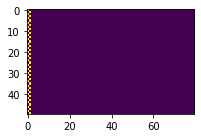

09-26 04:42:04
Mean Train Loss: 0.04098517879269445
Mean Train Seq2Seq Loss: 2.693193706740347
Train CER: 0.7675208268815574
Eval Count 50 | 따로 음료를 가져가서 마셔도 되나요?  => <s>아르데 바지머 신마시거되나요?</s> => 아드              나되요??


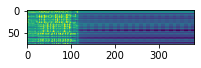

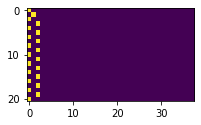

Eval Count 64 | 예약 할 수있는곳 인가요? ___ => <s>예ㅑㄱ 하ㅡㅇㄴ메어시아네요?</s> => 예약         요요?    


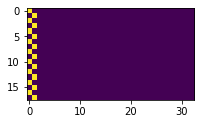

09-26 04:42:26
Mean Evaluation Loss: 0.04165690162822517
Mean Evaluation Seq2Seq Loss: 2.938123535916436
Evaluation CER: 0.755355573735721


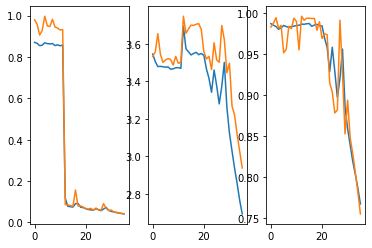

-------------------------------------------------------------------------------------------------------
09-26 04:42:26
Count 200 | 할인 받을 수 있는 통신사는 뭐뭐 있나요? ___ => <s>아이마이ㅜ에드마으머아ㅣㅆ나요?</s> => 생린                 있있요?    


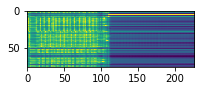

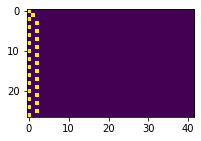

Count 400 | 다시한번만 말해주세요 ___ => <s>아시고토만 바이 시되ㅔ요?</s> => 혹시시        요   


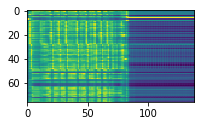

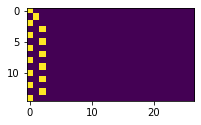

Count 600 | 오토바이 주차 가능한공간이 있을까요? ___ => <s>아하 시차가느하 그가ㅏ미이시가요?</s> => 매     가         요?요     


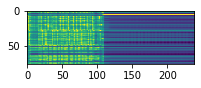

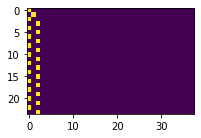

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>아ㅡ고제시체고카나시이크즈데세지사고 가시드갈이프즈제 가거 시이 읐나요?</s> => 아      코                                있 있 ?     


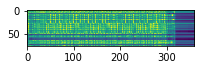

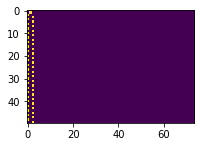

Count 808 | 화장실이 매장 내에 있나요? _ => <s>아아이이다므이있나요?</s> => 할일  이  이  있나요?   


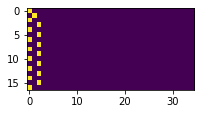

09-26 04:50:52
Mean Train Loss: 0.05083764568083743
Mean Train Seq2Seq Loss: 2.9350792970766104
Train CER: 0.8201505411790561
Eval Count 50 | 이번주 일요일에 예약했는데 취소해야겠습니다 _____ => <s>아가지이예약하사는데지스아매시다.</s> => 죄송한세  예약        습습           


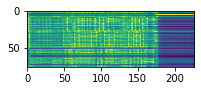

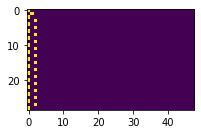

Eval Count 64 | 배달 최소주문금액 있어요? __ => <s>아사 시소시믄드에이나요?</s> => 혹시  시      나요?   


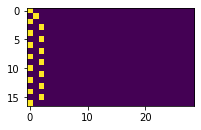

09-26 04:51:15
Mean Evaluation Loss: 0.04747474415236868
Mean Evaluation Seq2Seq Loss: 3.165467500716512
Evaluation CER: 0.7668120956822627


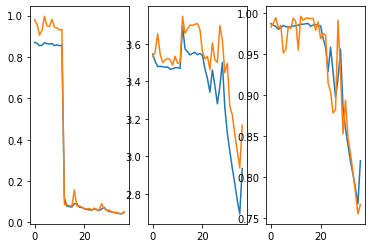

-------------------------------------------------------------------------------------------------------
09-26 04:51:15
Count 200 | 몇 명 이상이어야 단체룸 이용이 가능한가요? ___ => <s>오느ㅣ마에 자지므잉 가녀하요?</s> => 오늘                    요     


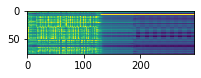

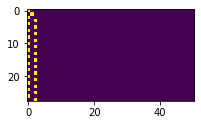

Count 400 | 메뉴 추가에 돈이 드나요?  => <s>이ㅠ 지가에 조이되나요?</s> => 이료 주    되되나요?  


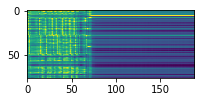

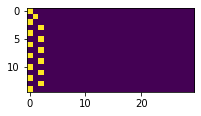

Count 600 | 다른 음식 사가서 같이 먹어도 되나요? _ => <s>다이는시사ㅏ소 파시어거도되나요?</s> => 평일              되나요?   


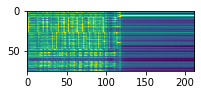

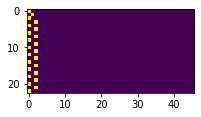

Count 800 | 안녕하세요 이용금액에서 제가 할인받을 수 있는 금액이 얼만지 궁금합니다 __________ => <s>안녀ㅏ잉ㅎ잇ㄴ드에지절시뎌하연마이 시ㅣ믄드메디분만지그몬안잊요.</s> => 안녕하세요                                             


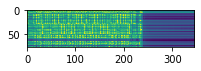

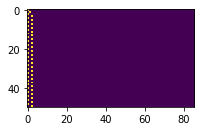

Count 808 | 크리스마스날 영업하나요? ___ => <s>스스마시마 예영야하나요?</s> => 크마      영약나나요요?  


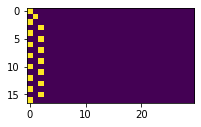

09-26 04:59:46
Mean Train Loss: 0.04202731156861443
Mean Train Seq2Seq Loss: 2.687271336347952
Train CER: 0.7646379459120022
Eval Count 50 | 이번주 주말에 두명이서 할건데 가능할까요? ____ => <s>예언지주마이 지명이사건데 가능할까요?</s> => 이번주주요말          능요요요?       


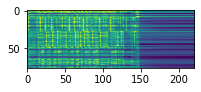

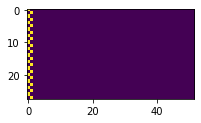

Eval Count 64 | 아기 의자 몇 개월부터 앉을 수 있나요? _ => <s>아그 ㄷ몇새탄드듰나요?</s> => 아           요   요요요?    


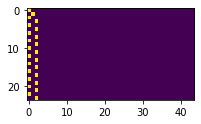

09-26 05:00:08
Mean Evaluation Loss: 0.04052956121035384
Mean Evaluation Seq2Seq Loss: 2.871170838558802
Evaluation CER: 0.7350885296381832


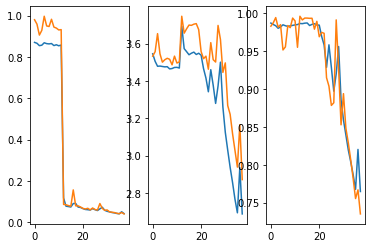

-------------------------------------------------------------------------------------------------------
09-26 05:00:09
Count 200 | 학생 할인은 몇 살 부터 받을 수 있나요? __ => <s>하사 하인은 몇사버사드 수있나요?</s> => 할인 할인은 몇 살부터  받  수  나요?   


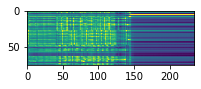

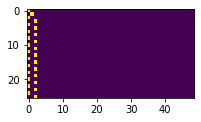

Count 400 | 빨간날도 문 열어요? ___ => <s>배란녀도머되아요?</s> => 배달   떻  되나요?   


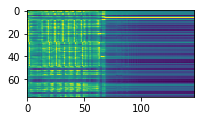

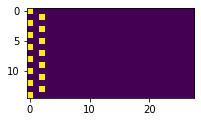

Count 600 | 생일 할인은 날짜 기한이 있나요? ____ => <s>오이할인메 다깟타에 있나요?</s> => 어린이             있나요?   


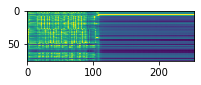

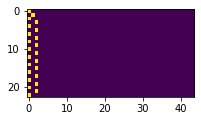

Count 800 | 제가 주차를 잘 못해서  서초점은 발레파킹이 안된다고 하는데 거기 지점은 되나요? ____ => <s>지가하 주차라서무태송 직포고응 바느퍼이 안며덩모 하는데 조이이 주저문되나요?</s> => 주가  주                                 요 요나요? ?    


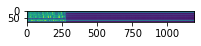

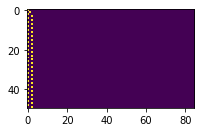

Count 808 | 쿠폰 중복 할인 되나요? ____ => <s>가ㅜ포인 신무가인되나요?</s> => 학민  할 할인인되나요?     


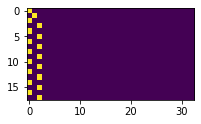

09-26 05:08:45
Mean Train Loss: 0.03821798929990212
Mean Train Seq2Seq Loss: 2.5566995972988784
Train CER: 0.737863312251441
Eval Count 50 | 빵 배달 가능한가요? ____ => <s>다우 베다 가능한가요?</s> => 발렛파   가능한가가요?   


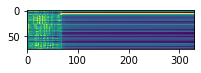

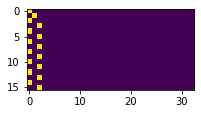

Eval Count 64 | 아뇨 1시반으로 예약변경했었어요 _____ => <s>아느 가시간메 예약 강겨이쇠어요?</s> => 네  시간 예약약       요      


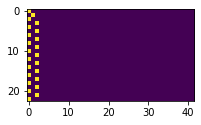

09-26 05:09:07
Mean Evaluation Loss: 0.03874266372725782
Mean Evaluation Seq2Seq Loss: 2.851305676276869
Evaluation CER: 0.7319252393253305


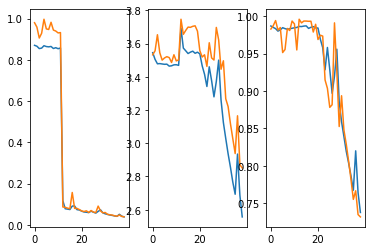

-------------------------------------------------------------------------------------------------------
09-26 05:09:08
Count 200 | 수내동인데 배달 가능한가요? ___ => <s>새이발인데 ㅂ가이 가능한가요?</s> => 생일이       가가능가요?   


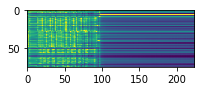

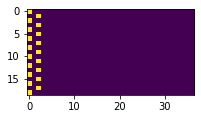

Count 400 | 내일 3시에 예약했는데 6시로 변경하고 싶어요 ___ => <s>매태싱 준데시트여ㅓ지ㅓ요.</s> => 내일                           


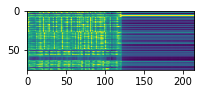

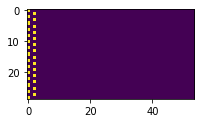

Count 600 | 마감 시간이 언제인가요? ___ => <s>아란 시ㅏㄴ이 언지있가요?</s> => 영업 간이 언제제인가요?    


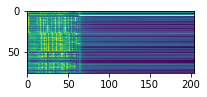

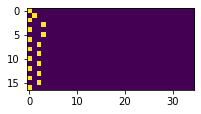

Count 800 | 그러면 35분 뒤에 찾으러 가겠습니다 ___ => <s>재아연 전지고는이에 자사걸있수이다.</s> => 저가             습니다 다    


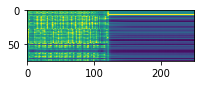

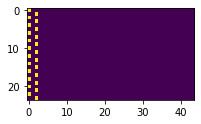

Count 808 | 스테이크와 샐러드 음료 주문 할께요 얼마인가요? 현대카드 있는데 할인 되나요? ______ => <s>새이커오 대도므 시바하기 알하인가료 머이 가는는데 가이 되나요?</s> => 생k 드                                   되나되??? ??  


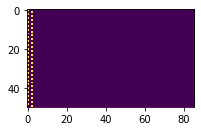

09-26 05:17:41
Mean Train Loss: 0.0382145681800106
Mean Train Seq2Seq Loss: 2.53540970172079
Train CER: 0.7321039786494364
Eval Count 50 | 마지막 주문은 몇시까지 해야하나요? ___ => <s>아지마지므는 몇 시까지이ㅑ하나요?</s> => 마지막     몇몇까까까지  하하나요?  


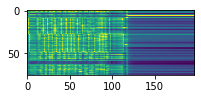

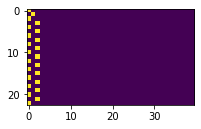

Eval Count 64 | 대중교통 무엇을 이용하죠? __ => <s>애전브펀도살이이영하죠?</s> => 매장          죠 ?  


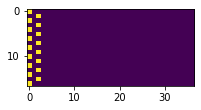

09-26 05:18:03
Mean Evaluation Loss: 0.03835255863280178
Mean Evaluation Seq2Seq Loss: 2.856810040468928
Evaluation CER: 0.7486164325244785


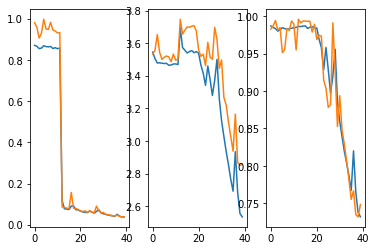

-------------------------------------------------------------------------------------------------------
09-26 05:18:03
Count 200 | 평일이랑 주말이랑 영업시간이 다른가요? ______ => <s>아잉느다조가이가여ㅏ지갈이갇딘가요?</s> => 아기랑               가인가요?     


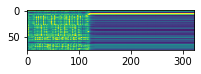

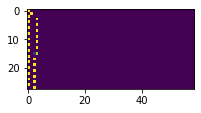

Count 400 | 차가 2대인데 둘다 발레파킹되나요? _ => <s>잔아드데네 드며살여거든되나요?</s> => 배달            되나요요?  


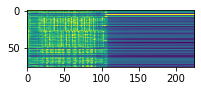

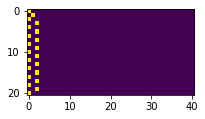

Count 600 | 아기용 메뉴가 따로있나요? __ => <s>오ㅑ간인 메뉴가가ㅏ있나요?</s> => 배뉴  뉴  가가 있나요?   


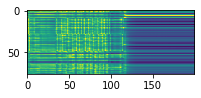

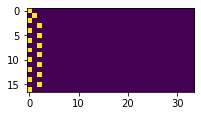

Count 800 | 안녕하세요 이용금액에서 제가 할인받을 수 있는 금액이 얼만지 궁금합니다 __________ => <s>즈ㅏ느요  잉 무에뉴소오 수마 할여 마며시이므그느이언만주 그ㅣ근 겁니다.</s> => 부                                        다 다 다 다 다


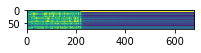

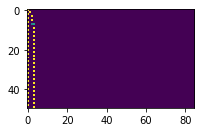

Count 808 | 혹시 고기 메뉴말고 다른것도 있나요? __ => <s>혁시 버이데뉴아보 다는 버기 있나요?</s> => 혹시 버레드는          나요? ? 


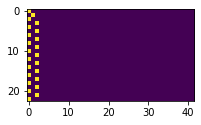

09-26 05:26:37
Mean Train Loss: 0.03812998558233254
Mean Train Seq2Seq Loss: 2.501029805259083
Train CER: 0.7232804616016031
Eval Count 50 | 이용하면 주차비가 얼마까지 나올지 궁금합니다 _____ => <s>잉ㄴ여 지차미난마까ㅣㄴ아 *ㅣ 구는 업니다.</s> => 이    주         궁금합니다          


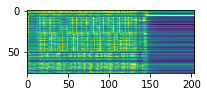

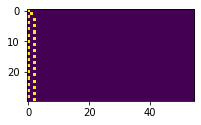

Eval Count 64 | 크리스마스날 영업하나요? ___ => <s>배ㅣ시마시알영업하나요?</s> => 밤 11시에시영영업하나요요   


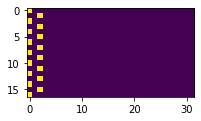

09-26 05:26:59
Mean Evaluation Loss: 0.03693699063814462
Mean Evaluation Seq2Seq Loss: 2.8217374293890853
Evaluation CER: 0.7101453646178901


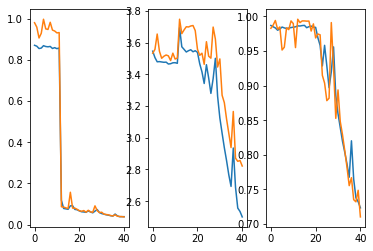

-------------------------------------------------------------------------------------------------------
09-26 05:26:59
Count 200 | 영업점 근처에 영화관이나 이런 거 있나요? ____ => <s>ㅇ*ㅓㅇ앗ㄹㄴ드저렝약어ㅏ가하느읃예야가ㅏ ㅆ나요?</s> => 10 전서  어   로 예약      나나요?   


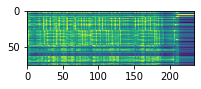

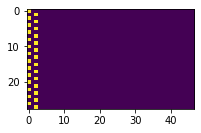

Count 400 | 중복으로 할인받을 수 있나요? ____ => <s>주ㅣㄴ고모 할이 받드ㅣ수 있나요?</s> => 생금 할받         나?     


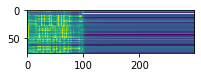

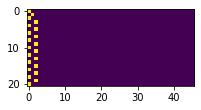

Count 600 | 런치시간은 언제까지에요? ___ => <s>여시시가으 연지가지ㅔ요?</s> => 오지 시간   언 주세요    


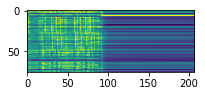

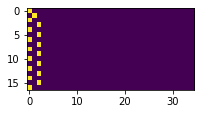

Count 800 | 전화로만 예약이 가능한가요? 앱으로도 예약할 수 있나요? 예약 방법 알려주세요 ______ => <s>저가한예약지 가능한가 매도에예햑할 수있나 예약안거가에주ㅔ요?</s> => 전가  약                            약                


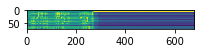

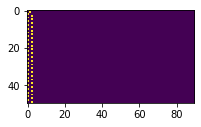

Count 808 | 할인 조건 충족해야 할인 되는거죠? ___ => <s>아이져퍼 주자수이아ㅏㅏ느마니하자ㅛ?</s> => 아기  점             가요?? 


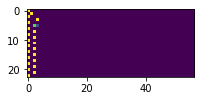

09-26 05:35:34
Mean Train Loss: 0.03513190735775014
Mean Train Seq2Seq Loss: 2.39383386811201
Train CER: 0.7008494320300811
Eval Count 50 | 건물 몇층에 있나요? ___ => <s>안몽뎌차메있나요?</s> => 주명      이있나나요? 


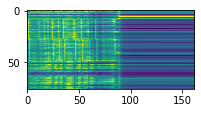

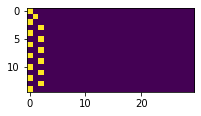

Eval Count 64 | 수유실 혹은 귀저귀 가는 장소 있는 지 궁금합니다 ___ => <s>으느엘시엘 가그 재장딜 가능 간도가인몬세 그구합니다.</s> => 오늘                             


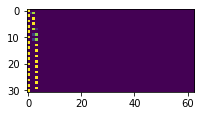

09-26 05:35:57
Mean Evaluation Loss: 0.035629472821728424
Mean Evaluation Seq2Seq Loss: 2.716573403853644
Evaluation CER: 0.6863957867662819


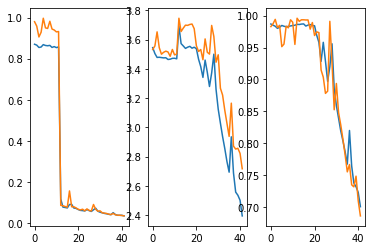

-------------------------------------------------------------------------------------------------------
09-26 05:35:57
Count 200 | 주차 공간이 있나요? __ => <s>주차오가이 있나요?</s> => 주차공공간이 있요?    


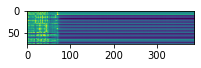

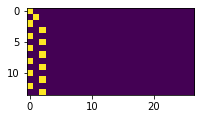

Count 400 | 런치타임에 11명 예약하고 싶은데 가능할까요? ____ => <s>안기타이에 자ㅏ능이악가홀 숲은데 거하ㅏ요?</s> => 아치 이일                 요요요     


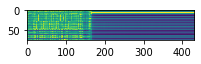

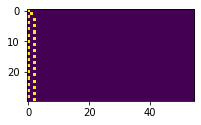

Count 600 | 블랙라벨 스테이크 아직도 판매해요? ___ => <s>스ㅣ넨아베에징아지보 ㅍ데ㅔ요?</s> => 스럼             해 요요    


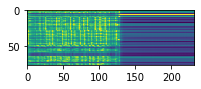

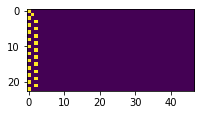

Count 800 | 멤버십 카드 할인 되나요? __ => <s>몀버시크타존갈인되나요?</s> => 멤버십 카드 할인되되되요?   


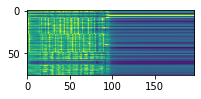

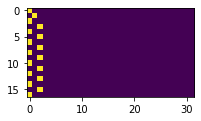

Count 808 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>네 크 거리 카테커펗시엔트 주게 지가아고 *ㅐ느이 타이드 주데려 다끌 수 있나요?</s> => 네 그드 드   코 넛 넛 개               개          요 요?    


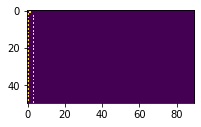

09-26 05:44:35
Mean Train Loss: 0.034627221347395376
Mean Train Seq2Seq Loss: 2.3625402846327663
Train CER: 0.693401546625435
Eval Count 50 | 혹시 이번달에 쉬는날이 있나요 ? ___ => <s>호시ㅣ반타여 시엔마이 있나요?</s> => 혹시  레       나?   나요?  


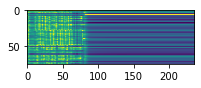

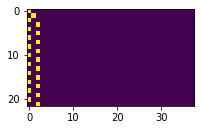

Eval Count 64 | 오늘 몇 시에 오픈하나요? ___ => <s>온*ㅕㅊ시여슨하나요?</s> => 오늘일몇시에   픈픈하나요?   


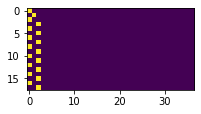

09-26 05:44:57
Mean Evaluation Loss: 0.035502737470813235
Mean Evaluation Seq2Seq Loss: 2.7202415706509893
Evaluation CER: 0.6986016975025952


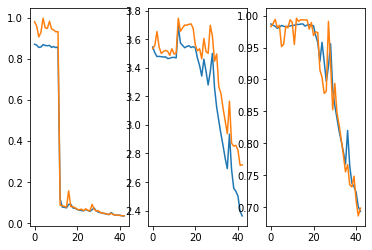

-------------------------------------------------------------------------------------------------------
09-26 05:44:58
Count 200 | 정확하게 다시 말씀해주세요 ____ => <s>저아파이 하신할시헤주세요?</s> => 죄사         주세세요    


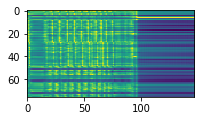

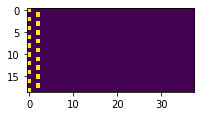

Count 400 | 어린이 할인을 받았을때 중복할인이 되나요? ______ => <s>바어ㅣ이하이ㅡ 바나 스ㅣ데 젱로 사이이되나요?</s> => 생일                    되나요?    


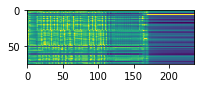

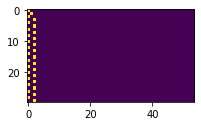

Count 600 | 근처에 무료주차장 있나요? __ => <s>안치이믈ㄴ 주차자이 있나요?</s> => 단체    주차차  있나요?  


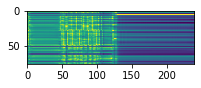

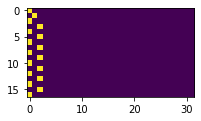

Count 800 | 카운터 직원분이랑 통화하고 싶어요 ____ => <s>앙퍼시그모예약 팡 하느싶ㄹ어요?</s> => 아 네     예  약 고 싶싶어요    


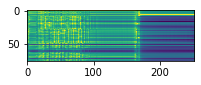

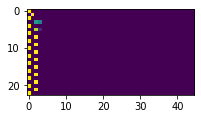

Count 808 | 아기 돌잔치를 할 장소를 찾고 있어요 아웃백에서 돌잔치 서비스를 제공하나요? ______ => <s>아기 고산제앨하정 종삭고ㅣ 시가료 하웃ㅅ배내소 곤젼기서글 수는 대금 하나요?</s> => 아기 친동 점                                  요       


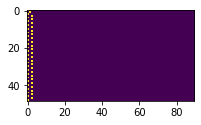

09-26 05:53:34
Mean Train Loss: 0.033863861093903415
Mean Train Seq2Seq Loss: 2.3366910683058943
Train CER: 0.6858929308724183
Eval Count 50 | 거기 위치가 어디인가요? __ => <s>아기구치어어데인가요?</s> => 아기의 치     인가요?  


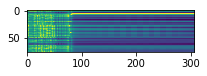

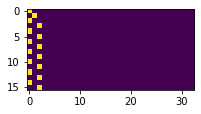

Eval Count 64 | 배달 했을 경우 맛은 같은가요? ______ => <s>으다 지스징오 자스 가되나요?</s> => 네                되나요요   


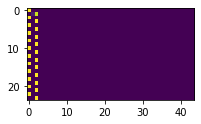

09-26 05:53:56
Mean Evaluation Loss: 0.034698247263821425
Mean Evaluation Seq2Seq Loss: 2.8063266028101066
Evaluation CER: 0.7271210098312902


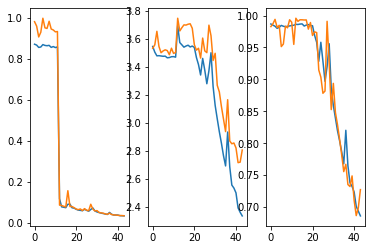

-------------------------------------------------------------------------------------------------------
09-26 05:53:56
Count 200 | 6월2일 5시 5명 김철수로 다시 예약해주세요 _ => <s>지ㅗ이이다*ㅓ수에이다장명 주드 시로 *ㅏ시여 애 주슸아요?</s> => 수0   1111117  1        요   


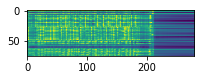

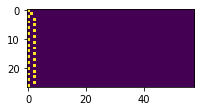

Count 400 | 지금 대기가 몇 시간 정도 되나요? _ => <s>이ㅜㄴ툰지걱탳시간보온 되나요?</s> => 이터  주   시      나요??  


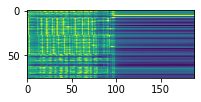

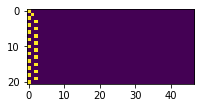

Count 600 | 일요일에도  운영하나요? ___ => <s>여뇨예아돈명하나요?</s> => 공늘       하나요?    


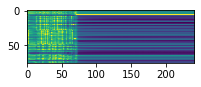

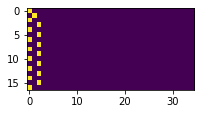

Count 800 | 차를 이용하는데 타임월드 사거리에서 아웃백으로 가려면 어느 방향으로 가야 하나요? ___ => <s>자이여아은데 파인으사으레나메도 가려낭어으마느거가나요?</s> => 제인                                       나       


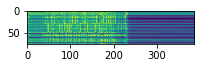

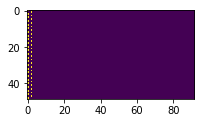

Count 808 | 회사로 배달받고 싶은데 가능한가요? ___ => <s>애사 배다아고 싶은데 가능한가요?</s> => 배달    고 싶은데 가능한가요요?    


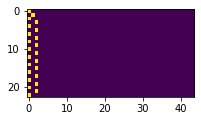

09-26 06:02:34
Mean Train Loss: 0.03262701813384426
Mean Train Seq2Seq Loss: 2.2875704582648635
Train CER: 0.6745045509941918
Eval Count 50 | 방금전화한 사람인데 예약 변경 가능한가요? _________ => <s>ㅇ므 자가 사으데 ㅇ야ㅑㄱ하하ㅡ할까요?</s> => 투   가     예약약약 능할할요요?            


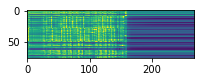

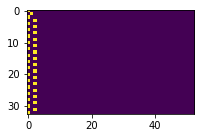

Eval Count 64 | 단체 예약도 가능한지요? ___ => <s>안치약도 가능한지ㅔ요?</s> => 단체 예예도  능능까요?    


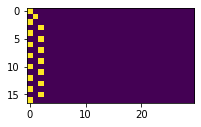

09-26 06:02:56
Mean Evaluation Loss: 0.03270252462375428
Mean Evaluation Seq2Seq Loss: 2.6216295353129073
Evaluation CER: 0.6699760047990402


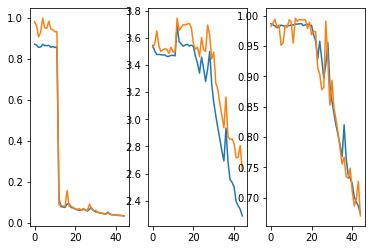

-------------------------------------------------------------------------------------------------------
09-26 06:02:57
Count 200 | 런치타임에 할인 되는 메뉴는 어떤게 잇조? __ => <s>언츠타으느 하할인대는 므뉴느 어떤에있ㄲㅈ요?</s> => 런치타임  할  는 메메 떤뉴떤 뭐  어요?  


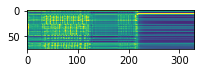

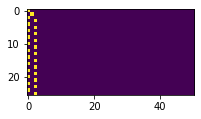

Count 400 | 지금 주차할 곳 있나요? __ => <s>지그 주차하에 고 이나요?</s> => 지금 주차     요요    


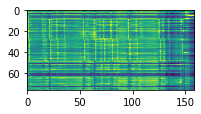

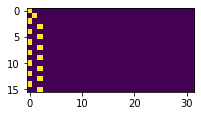

Count 600 | 가장 따뜻한 자리로 예약 가능 할까요? _ => <s>다낭까도자 자이료 예약 가능할까요?</s> => 창가자자리  리  예약 가능할요까?    


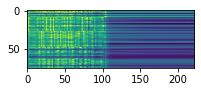

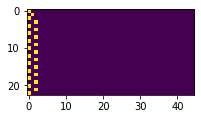

Count 800 | 아웃백에서 생일 할인이 되는지 궁금합니다 무엇을 어떻게 물어보실 건가요? _________ => <s>아웃배기서데이하이 이 되는게 고이고하늡니나 ㅁ승 어떡게무언무세겋나요?</s> => 아웃백에서                                    요 ?      


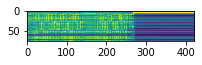

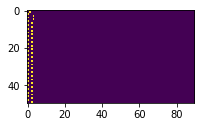

Count 808 | 얼마나 대기시간 걸릴까요? __ => <s>어며아 데유지강거일까요?</s> => 여러         있요요?  


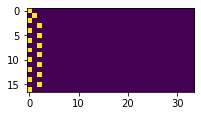

09-26 06:11:34
Mean Train Loss: 0.032034274798824605
Mean Train Seq2Seq Loss: 2.2293072284609083
Train CER: 0.6603145775619471
Eval Count 50 | 생일파티 하고 싶은데 혹시 몇명까지 될까요? _____ => <s>배이까질ㅌ일 소 주름마 가이욀아요?</s> => 생립   립             요요         


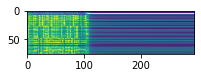

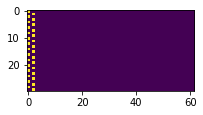

Eval Count 64 | 전화로도 예약할 수 있나요? __ => <s>장마에드 예약할 스있나요?</s> => 전화로 예약 할 수 있나 ?   


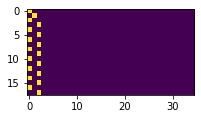

09-26 06:11:56
Mean Evaluation Loss: 0.03455414221893252
Mean Evaluation Seq2Seq Loss: 2.664940101471225
Evaluation CER: 0.6955494044101639


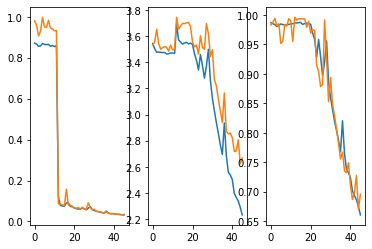

-------------------------------------------------------------------------------------------------------
09-26 06:11:56
Count 200 | 여자친구와 먹기 좋은 메뉴 좀 추천해주세요 ___ => <s>ㅁ가줌뫄고기손만느산 데타루숬어요?</s> => 지금                  있있요?   


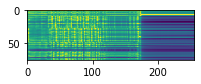

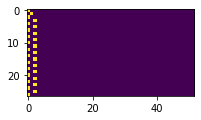

Count 400 | 지금 시즌 스페셜 메뉴가 있나요? __ => <s>즈근시주수비자메이대있나요?</s> => 그금  즌      비  있있나요?  


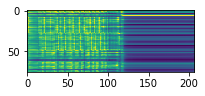

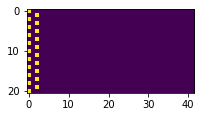

Count 600 | 주차는 어디에 하면 될까요? _ => <s>주차ㅡ 아잉ㅇㄹ은 될까요?</s> => 주차  은    될까될요??  


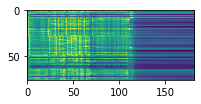

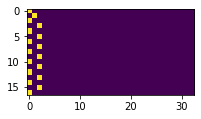

Count 800 | 안녕하세요 포장 예약을 하고 싶은데요 혹시 투움바 파스타도 포장이 가능한가요? _____ => <s>영하에요 보성이약으하거싶은데 복시근 버퍼스터도 보자이 가능한가요?</s> => 안녕하 요 예                             능가능가요가요      


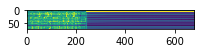

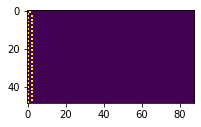

Count 808 | 저녁에 갈건데 지금예약해도 되나요? ___ => <s>저날이알건데 지곤 예약개도 되나요?</s> => 안송한  이           되요요?  


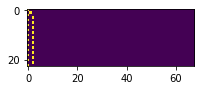

09-26 06:20:38
Mean Train Loss: 0.03178229590570815
Mean Train Seq2Seq Loss: 2.2137214660152753
Train CER: 0.6571598011239299
Eval Count 50 | 통신사와 카드할인 중복되나요? ____ => <s>통ㅁ시간마 가드으 중보 되나요?</s> => 통신사  은         나요?   


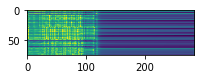

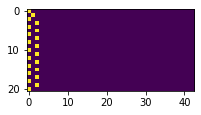

Eval Count 64 | 생일 할인이 따로 있나요? __ => <s>새을할인이 땔료이 이나요?</s> => 생일할인이 어이  나나요?   


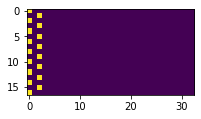

09-26 06:21:00
Mean Evaluation Loss: 0.032772497256469524
Mean Evaluation Seq2Seq Loss: 2.56766347684871
Evaluation CER: 0.6623787367332664


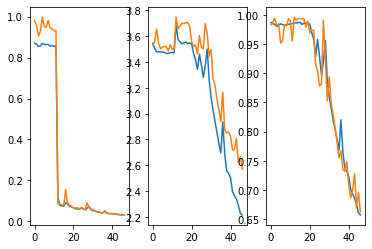

-------------------------------------------------------------------------------------------------------
09-26 06:21:00
Count 200 | 당일 예약 되나요? __ => <s>다이예오되나요?</s> => 당일 예약 되나요?   


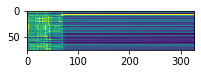

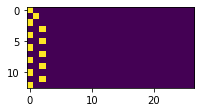

Count 400 | 전화말고도 예약할수 있는 다른 방법이 있나요? ___ => <s>오하ㅏㅗㅔ 예약하스있는 다르망거이 있나요?</s> => 오화    예예약        법 법이있나요?    


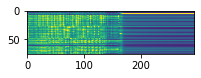

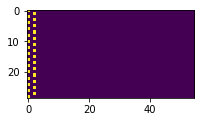

Count 600 | 어느 통신사가 할인이 더 많이 되나요? __ => <s>오느 동진저 ㅏㄹ인이 더항ㄴ 되나요?</s> => 오느 통신   할인이  되나나요?      


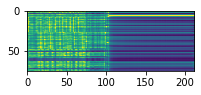

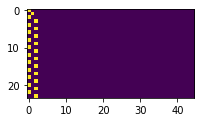

Count 800 | 날짜 변경하고 싶은데요 ___ => <s>아이차 주졍하고 싶은데요.</s> => 아 얘주주주하하고고은싶은데요 


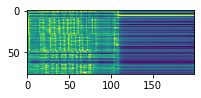

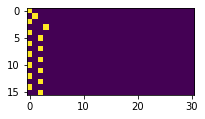

Count 808 | 차타고 가고 있는데 신세계백화점 맞은편 대로에서 어느 골목으로 들어가야하나요? _____ => <s>주그 공ㄹ 면데 지느드 하린 바인 든되로 새 어는데는 도로 그려가야하나요?</s> => 지금                           서 어    가하나하나??      


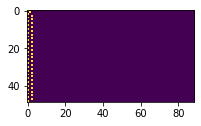

09-26 06:29:42
Mean Train Loss: 0.030397722045386953
Mean Train Seq2Seq Loss: 2.1553241713387052
Train CER: 0.6413159571896359
Eval Count 50 | 룸 예약 가능할까요? __ => <s>암예약 가능할까요?</s> => 예약    가능할까요?  


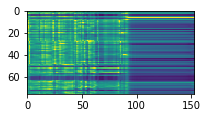

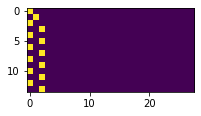

Eval Count 64 | 아기가 앉을수 있는 의자가 있나요? __ => <s>아기간메 ㅈ시ㅔ이메능자하있나요?</s> => 아기들 앉을    는  뉴가있있요요   


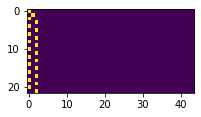

09-26 06:30:04
Mean Evaluation Loss: 0.03087768045791617
Mean Evaluation Seq2Seq Loss: 2.5358814328675
Evaluation CER: 0.6532589816253771


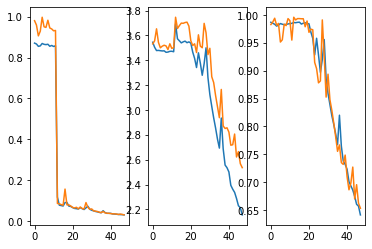

-------------------------------------------------------------------------------------------------------
09-26 06:30:04
Count 200 | 학생 할인과 생일 할인 중복 가능한가요? ____ => <s>학스하이나 슨이라인 중보 가능한가요?</s> => 학생 할인     인 복복복 가능한가요?     


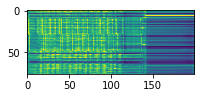

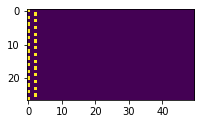

Count 400 | 주말에 어린이 30명 가능할까요? _______ => <s>주말에어린이 장시능 가능할까요?</s> => 주말에는        능능능할까?     할 ?


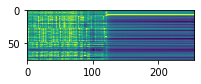

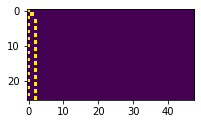

Count 600 | 혹시 배달도 가능한가요? ____ => <s>혹시쿠배자모 가능한가요?</s> => 혹시 배달    가가가가가한가요?


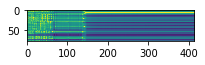

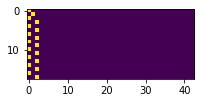

Count 800 | 저희 반 애들이 다 갈거라 한 30명이 갈것 같은데 졸업식날 단체예약 되나요? ______ => <s>젤간 배그ㅣ 아하고 한 좀시명이 가고가든데 조ㅗ신할에 반제 예약되나요?</s> => 제가 가                                      요   요   


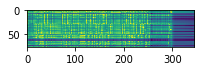

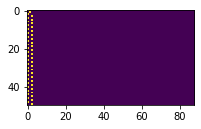

Count 808 | 얼마 이상 결제해야 주차가 가능한가요? _ => <s>언마이*ㅏㅇ*치 예야ㅑㄱ 주차가 가능한가요?</s> => 얼마v이상  약예약 주  가능한가가?   


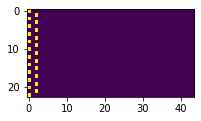

09-26 06:38:40
Mean Train Loss: 0.03082728897250383
Mean Train Seq2Seq Loss: 2.1642919677037122
Train CER: 0.6450705770095528
Eval Count 50 | 아웃백에서 서빙하는 직원과 통화 가능한가요? _____ => <s>아웃백애서떠이가아 지몬거자 어 어가능한가요?</s> => 아웃백에 물웃백  백               가가 가


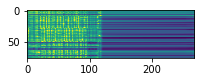

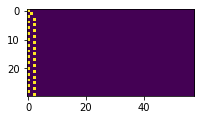

Eval Count 64 | 위치가 골목 안 쪽인가요? ___ => <s>며시가 고모안제 인가요?</s> => 혹시     언이 인가요?    


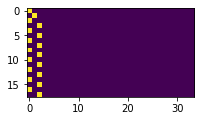

09-26 06:39:03
Mean Evaluation Loss: 0.03023671851486297
Mean Evaluation Seq2Seq Loss: 2.5575123588287583
Evaluation CER: 0.6751911257682507


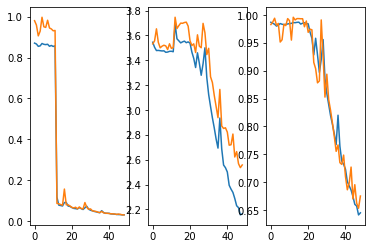

-------------------------------------------------------------------------------------------------------
09-26 06:39:03
Count 200 | 6시 30분으로 예약했는데 7시로 변경해주세요 __ => <s>아소슬ㄴ제폰문모예약 그녀다백스로ㅗ 가명후됫까요?</s> => 6시            으로 변경경경될까요?   


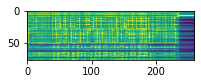

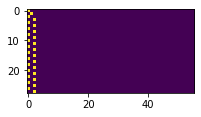

Count 400 | 거기 휴무일이 언제에요? _ => <s>거기승ㅇ이잉ㄴ제에요?</s> => 거기 생일디  이세요    


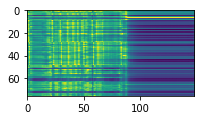

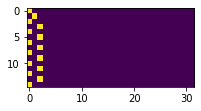

Count 600 | skt vip회원 할인률을 알고 싶어요 ___ => <s>*ㅕㅊ슽*ㅡ꾸려치이상 할인 이여 가가시어요?</s> => skt                      


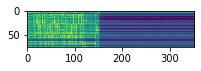

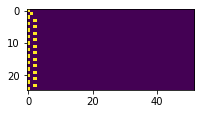

Count 800 | 금요일 저녁에 동창회 잡으려고 하는데 2층에 25명 정도 예약 받을 수 있나요? _____ => <s>그느 전녀기 벙 장이 다고야고 하는데 *ㄹ *ㅏ느 하*ㅏㅇ명정도 예약핟일 수 있나요?</s> => 어   녁 저녁  가  그                로 예 예   수 수나있나요?    


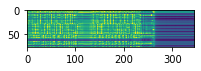

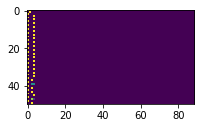

Count 808 | 부드러운 고기 메뉴가 있나요? _ => <s>구드ㅏㅇ 코시 메뉴가 있나요?</s> => 근폰    메메뉴 있있요?    


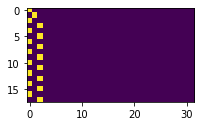

09-26 06:47:39
Mean Train Loss: 0.028454841689315793
Mean Train Seq2Seq Loss: 2.091548117849085
Train CER: 0.6248369486448621
Eval Count 50 | 아웃백 보라매에 있는 것 맞나요? __ => <s>아웃백보이 있는거맞나요?</s> => 아웃백  북에도 맞맞요?        


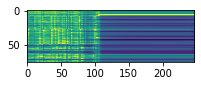

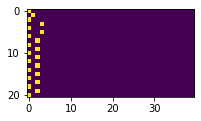

Eval Count 64 | 장사하는 시간 알려주세요 ___ => <s>단차하믄시가 떠려혀주세요?</s> => 런차   시  알려려세요    


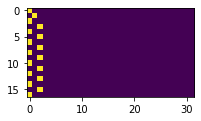

09-26 06:48:02
Mean Evaluation Loss: 0.029416766439324053
Mean Evaluation Seq2Seq Loss: 2.4350455492123713
Evaluation CER: 0.6306188519486988


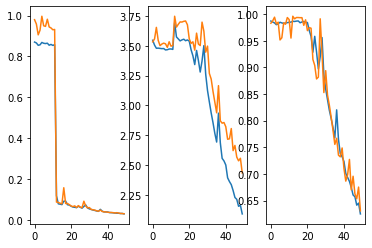

-------------------------------------------------------------------------------------------------------
09-26 06:48:02
Count 200 | 제가 쓰는 통신사 카드 할인되나 궁금해서요 __ => <s>지거스라 도이삭 카드 할인되나 븡거해ㅔ요?</s> => 제가카드   할인인 할인인            


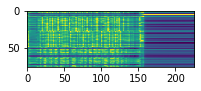

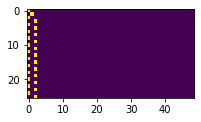

Count 400 | 배달료를 따로 받나요? ___ => <s>배달여에 따로 갇나요?</s> => 배달   따로받받나요?    


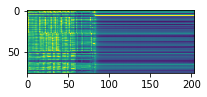

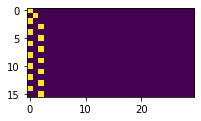

Count 600 | 제가 강남역인데 어디로 가면되나요? ___ => <s>주가 강한며닌데 어이로 가근 되나요?</s> => 지한 강남공 는데       되되요? ? 


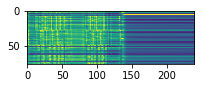

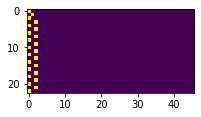

Count 800 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? _________ => <s>근녀하엥요겅업시간 갈를고 믄이두립니다 주말으 이 *ㅕㅊ시고 픈하시나요?</s> => 안녕하세요 영업시        하   하   관           주 요나요?       


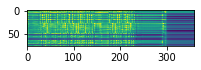

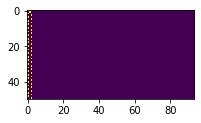

Count 808 | 돌잔치예약 가능한가요? ____ => <s>으점시 예약 가능한가요?</s> => 음잔   약 약가가한가요?   


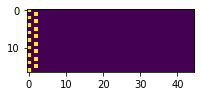

09-26 06:56:44
Mean Train Loss: 0.027669449695945557
Mean Train Seq2Seq Loss: 2.0495692875107894
Train CER: 0.6152306893173455
Eval Count 50 | 10명이 한꺼번에 앉을 수 있는 자리가 있나요? ___ => <s>ㅇ명이한 거한앉메시믄 자리하 있나요?</s> => 10명  한          있있요??         


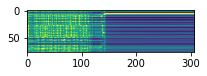

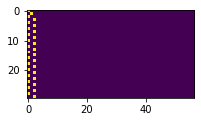

Eval Count 64 | 평일에는 몇 시부터 영업하세요? _____ => <s>정이욘 몇 시오트라 어파시ㅔ요?</s> => 평일일오    부터 오픈  요요 ?    


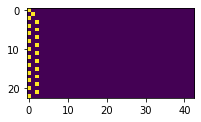

09-26 06:57:06
Mean Evaluation Loss: 0.028656798454982334
Mean Evaluation Seq2Seq Loss: 2.4685581428679297
Evaluation CER: 0.638985564264746


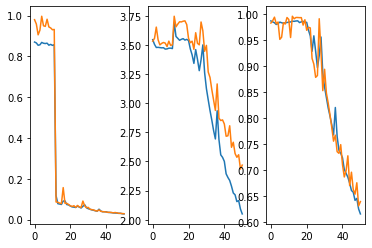

-------------------------------------------------------------------------------------------------------
09-26 06:57:07
Count 200 | 주차장이 따로 마련되어 있나요? _ => <s>지차장이가로 가는메 있나요?</s> => 주차장 가가      있있요?   


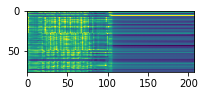

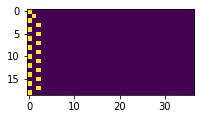

Count 400 | 이따 방문할건데 혹시 거기 위치가 어디쯤 되나요? __ => <s>이다가할건데 혹시버으이치가 거이시되나요?</s> => 이달                    되나??    


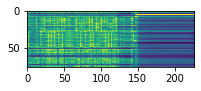

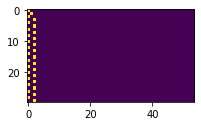

Count 600 | 매장 오픈시간이 몇시에요? __ => <s>네우븐시간이 몇시에요?</s> => 매픈 오픈시시간이이요?     


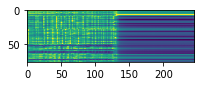

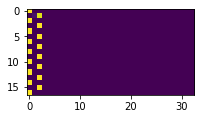

Count 800 | 아웃백의 정기적인 휴무일이 있나요? ___ => <s>아웃백이 저기장에이무말인이 있나요?</s> => 아웃백이 전국     이이이이있나요?   


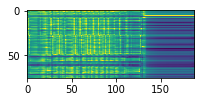

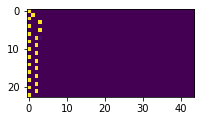

Count 808 | 죄송합니다 급하게 예약 변경하려고 하는데 오늘 말고 내일 저녁은 가능한가요? _______ => <s>자도흡니다 ㅇ파데 예약*ㄴ경하려 고 하는데 가로늘달구대이산규가 가능한가요?</s> => 죄송합니다 급  명  단체예하고하 하데                가가가가요? ? ? ? 


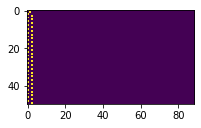

09-26 07:05:45
Mean Train Loss: 0.027023748571733848
Mean Train Seq2Seq Loss: 2.0015063925238996
Train CER: 0.6032546911006255
Eval Count 50 | skt멤버쉽할인 되나요? _ => <s>샅틈ㅍ시 할인 되나요?</s> => 파k카드  할인 되나되요? 


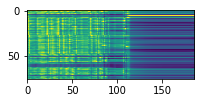

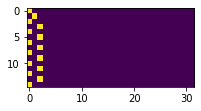

Eval Count 64 | 어떤 방법으로 예약 가능할까요? ____ => <s>오펀덩도을 예약 가능할까요?</s> => 돌폰  로 예약  능가요요?       


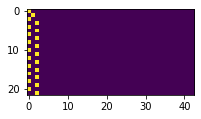

09-26 07:06:07
Mean Evaluation Loss: 0.027621107047819997
Mean Evaluation Seq2Seq Loss: 2.4156873031991903
Evaluation CER: 0.6184600495977741


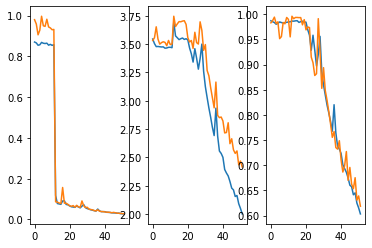

-------------------------------------------------------------------------------------------------------
09-26 07:06:07
Count 200 | 주차 공간이 좁던데 지금 주차 가능한가요? __ => <s>주차고가이 오펀데 지금 주차 가능한가요?</s> => 주차공간 이 좁던데 지금 주차 가능한가요?   


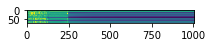

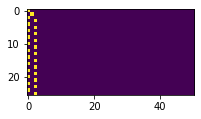

Count 400 | 쉬림프종류메뉴가있나요? __ => <s>세알 크종우느뉴하 있나요?</s> => 담이트   가  나요요   


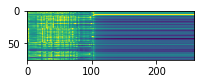

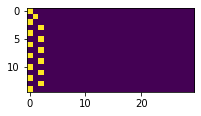

Count 600 | 혹시 고기 메뉴말고 다른것도 있나요? ___ => <s>며시 고이마드 갈인붓데 있나요?</s> => 혹           인 있나나나요?    


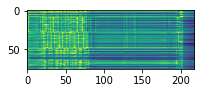

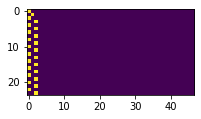

Count 800 | 저희 반 애들이 다 갈거라 한 30명이 갈것 같은데 졸업식날 단체예약 되나요? ______ => <s>저이 간메데이다 가고요 아자시영할거같은데 머망 반체 예약되나요?</s> => 저희                                    요되요?        


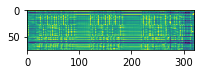

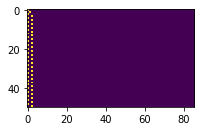

Count 808 | 오늘 몇시까지 영업하세요? _ => <s>오느몇시가이 ㅇㅇ업하세요?</s> => 오늘 몇시시까 영업시요요?? 


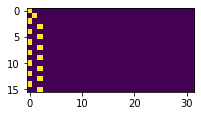

09-26 07:14:45
Mean Train Loss: 0.026479188781039945
Mean Train Seq2Seq Loss: 1.9729709887438311
Train CER: 0.5963507415986914
Eval Count 50 | 혹시 오늘 생일인 사람이 있으면 할인 되나요? ____ => <s>혹수뉴*이사이명 할인 되나요?</s> => 혹생 생일       할할할되되되나??         


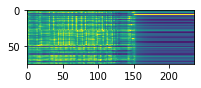

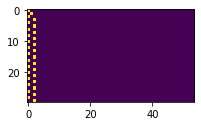

Eval Count 64 | 배달이 가능한 지역이 어디인가요? ___ => <s>바들이 간서이 어이있나요?</s> => 아드운 어이 역이있있나요?        


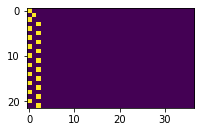

09-26 07:15:07
Mean Evaluation Loss: 0.03260326150796975
Mean Evaluation Seq2Seq Loss: 2.767575190006866
Evaluation CER: 0.6347755249818972


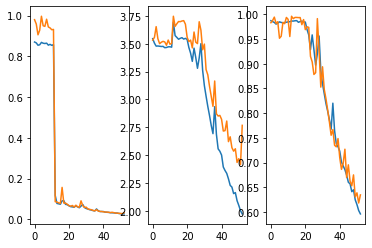

-------------------------------------------------------------------------------------------------------
09-26 07:15:07
Count 200 | 아이들이 5명 가는데 아기 의자 다 준비되나요?  => <s>알이드이 ㅏㄹ망가는데 아키의사다 장기 되나요?</s> => 아이랑       데      장장자  나요?  


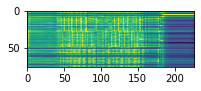

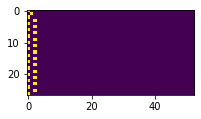

Count 400 | 위치좀 알고싶습니다 ____ => <s>기치덤 말고싶습니다.</s> => 위치좀 알고싶습니다     


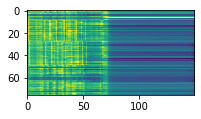

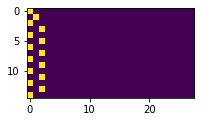

Count 600 | 단체 할인은 몇 명부터 가능한가요? ____ => <s>재차할안멘 명보소가능한가요?</s> => 주송한데  몇     가능한한가요      


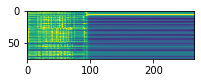

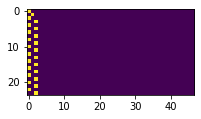

Count 800 | 의자 밑 콘센트에 핸드폰 충전하다가 그대로 두고 왔어요 핸드폰 혹시 보셨나요? ______ => <s>이자이 고년제 배느 트슨에하어허근으이 주뫄ㅏ수룐 가ㅡㄴ 포ㅗㄱ 기고되나요?</s> => 제가                                      되되나       


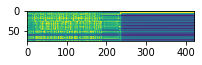

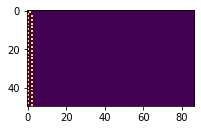

Count 808 | 혹시 단체 예약도 받으세요? _ => <s>혹시 반체야도 가르세요?</s> => 혹시 단체 예약도 받으세?   


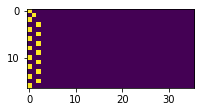

09-26 07:23:44
Mean Train Loss: 0.026844957559366223
Mean Train Seq2Seq Loss: 1.962630637214039
Train CER: 0.5940098336186839
Eval Count 50 | 제일 인기있는 스테이크 추천 부탁드립니다 _______ => <s>*일이제인아하데이크레 주탄타들립니다.</s> => 생일  인이           립 다       다 다


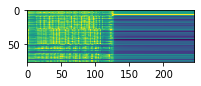

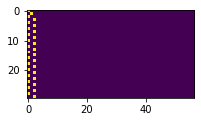

Eval Count 64 | 학생할인은 몇%인가요? _____ => <s>하생 할인믄 몇버즌두 인가요?</s> => 학생할할인은몇%몇 인?요?    


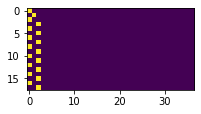

09-26 07:24:07
Mean Evaluation Loss: 0.02788088526190876
Mean Evaluation Seq2Seq Loss: 2.353834337540662
Evaluation CER: 0.6237890371104027


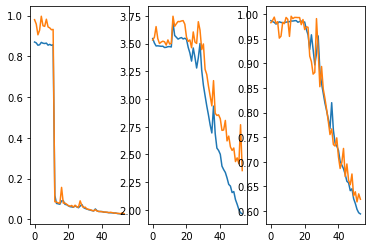

-------------------------------------------------------------------------------------------------------
09-26 07:24:07
Count 200 | 채식주의자인데 먹을 수 있는 메뉴가 있나요? __ => <s>사스드이자인ㄷ 어을 스이는 메뉴가 있나요?</s> => 학스이  먹을    있는  메뉴가뉴 있나요?   


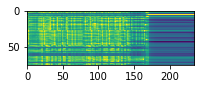

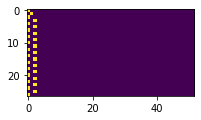

Count 400 | 런치타임을 알려주세요 __ => <s>런치타요 할여주세요.</s> => 런치타임  알주주세요   


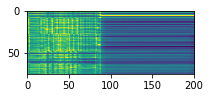

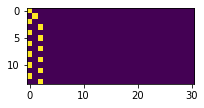

Count 600 | 오후에 직원들 휴식 시간이 있나요? ___ => <s>오흐에 주문애 수식시간이 있나요?</s> => 오후에 주에 주   시간간이 있나요?   


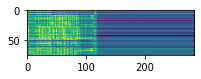

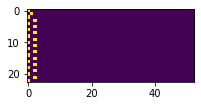

Count 800 | 저희 반 애들이 다 갈거라 한 30명이 갈것 같은데 졸업식날 단체예약 되나요? ______ => <s>배망배이 ㅇ칼건 *ㅗㅇ*ㅣ명이갈고가은데 조신마 단제 예약되나요?</s> => 1메                                    요요          


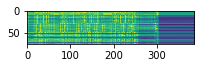

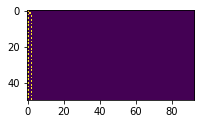

Count 808 | 단체 예약도 가능한가요? ___ => <s>단체ㅖ 예약도 가능한가요?</s> => 단체 예약도 가능한가요?    


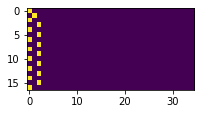

09-26 07:32:50
Mean Train Loss: 0.025567290354276066
Mean Train Seq2Seq Loss: 1.9088500589789896
Train CER: 0.5802470218391157
Eval Count 50 | 주차 할 곳이 있나요? __ => <s>주찰 고시 있나요?</s> => 주차      있있요요?  


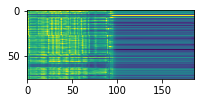

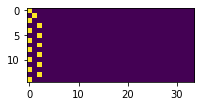

Eval Count 64 | 케이티 건물에서 꺾으면 될까요? ____ => <s>세이크이언믈엔마아픈현될까요?</s> => 패밀 세이    얼얼    될까요?요  


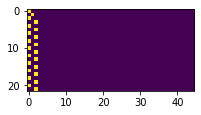

09-26 07:33:12
Mean Evaluation Loss: 0.026566432904486525
Mean Evaluation Seq2Seq Loss: 2.311997378751712
Evaluation CER: 0.6144031668696711


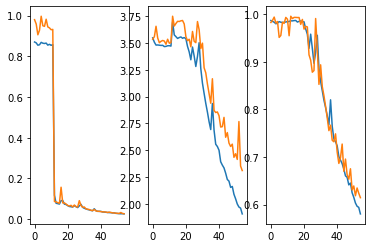

-------------------------------------------------------------------------------------------------------
09-26 07:33:12
Count 200 | 생일 할인 이벤트가 있나요? ____ => <s>생일할은 이엔추가 있나요?</s> => 생일 할인은 벤트  있있나?     


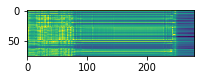

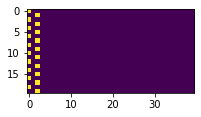

Count 400 | 이유식 가지고 가려는데 혹시 데워 주실 수 있나요? _ => <s>우ㅠ시가지 보달려뎣시베 어수줄수 있나요?</s> => 유치   에            실실수 있나요?    


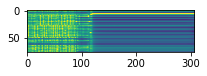

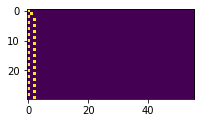

Count 600 | 케이터링 서비스도 제공하나요 _ => <s>세이크인사ㅣ스도트보하나요?</s> => 스테이크         나나요?


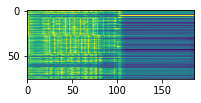

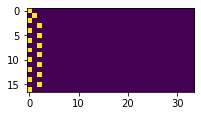

Count 800 | 아웃백은 언제까지 식사 가능한가요? ___ => <s>아웃백으으 언제까지 시사가 가능한가요?</s> => 아웃백  은 지제까지 차가가능한가요?   


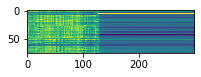

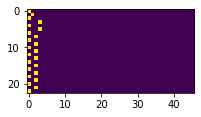

Count 808 | 단체라 인원이 많은데 다음주 일요일 오후 5시에 20명 룸으로 예약 가능할까요? _____ => <s>단처ㅏ*먼이가는데 잦ㅇ요요오호  *ㅜ며무누로 예약 가능하가아요?</s> => 단체  가고   는데  명                  예약 약 능가능한요요       


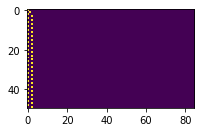

09-26 07:41:52
Mean Train Loss: 0.025192705248886883
Mean Train Seq2Seq Loss: 1.877599423023248
Train CER: 0.5739696302836235
Eval Count 50 | 1월1일에 영업하나요? __ => <s>이야일이 영업하나요?</s> => 일월1일에 영업업하나요?  


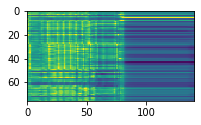

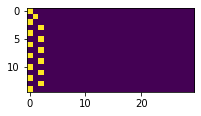

Eval Count 64 | 5분안에 도착할텐데 자리 있나요? ____ => <s>오ㅕ말에 보타 카딴 덴 가로 있나요?</s> => 모모별에 가   가   따로  있나??  


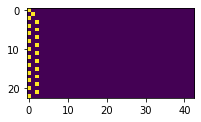

09-26 07:42:14
Mean Evaluation Loss: 0.025491410418992257
Mean Evaluation Seq2Seq Loss: 2.348539195357011
Evaluation CER: 0.6062760999818435


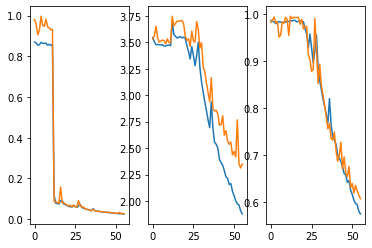

-------------------------------------------------------------------------------------------------------
09-26 07:42:14
Count 200 | 현재 가능한 할인이벤트는 어떤게 있나요? ___ => <s>젼제 가므항 할인이넨츠는 어떤ㅎ게 있나요?</s> => 주중 할 할 할  는  어어게게 나요요?    


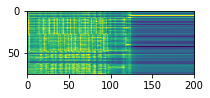

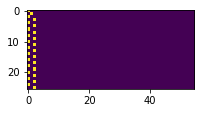

Count 400 | 단체 할인도 있어요? ___ => <s>단체하 ㅎ인외 있어요?</s> => 단체 할인  있어요?    


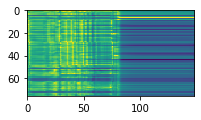

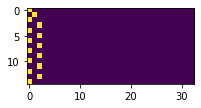

Count 600 | 다음주 월요일에 언제까지 영업하나요? __ => <s>담주어열엔시까지 영앙하나요?</s> => 다음주      시까까 영업하나요     


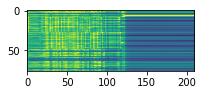

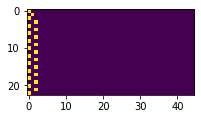

Count 800 | 오늘 저녁 6시 예약했는데 좀 늦을 것 같네요 저녁 7시로 변경할 수 있나요? ______ => <s>오느 저뇨 *시예약했는데 조모로세까깐데요 바하에잏시오 바그할 수 있나요?</s> => 오늘 저녁  시에 예약했는데데                      수 있         


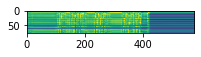

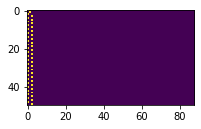

Count 808 | 예약 좀 잡아주시겠어요? ___ => <s>*ㅖ약 텸 자마으숬릈꺼요?</s> => 예약 좀  바알 수 요?요   


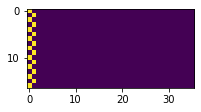

09-26 07:50:51
Mean Train Loss: 0.024358307573355668
Mean Train Seq2Seq Loss: 1.841404717415184
Train CER: 0.5642406446356135
Eval Count 50 | 10명이 한꺼번에 앉을 수 있는 자리가 있나요? ___ => <s>*명이하가겅이 핝들 수 있는 자리가있나요?</s> => 10명이 기저귀를귀   수 수 있자  있나?      


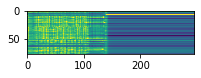

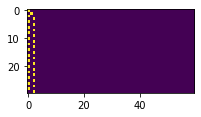

Eval Count 64 | 다음 주에 쉬는날 있어요? __ => <s>자하ㅡㅁ 지시는 마ㅔ요?</s> => 다음주식시  는  에요??   


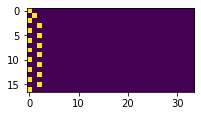

09-26 07:51:14
Mean Evaluation Loss: 0.025139618023545456
Mean Evaluation Seq2Seq Loss: 2.3940456045088823
Evaluation CER: 0.6036412879927776


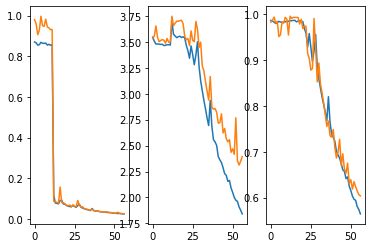

-------------------------------------------------------------------------------------------------------
09-26 07:51:14
Count 200 | 토요일 12시에 10명 긴 테이블로 예약 되나요?  => <s>고요일**시 **ㅕ*ㅣㅁㅌ이으로 예약 되나요?</s> => 토요일 12시  1      예예약약되되나요?   


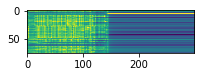

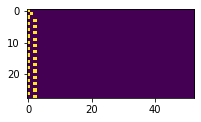

Count 400 | 신정에도 영업하나요? ___ => <s>진ㅊ이 도 영업하나요?</s> => 추석에도 영업하나요?    


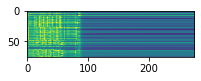

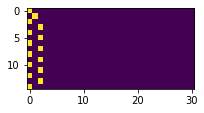

Count 600 | 예약 좀 하려고요 예약하고 싶은데요 ___ => <s>예약좀 하려고료 예약하ㅏ고 싶은데요.</s> => 예약하 고하고 예약예약하고 싶은데요    


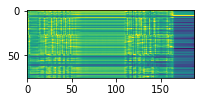

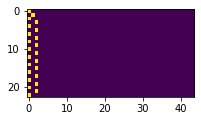

Count 800 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>제곰한데 오벗ㅂ카드래푸시엤는데 주ㅣㄴ고걸대보시버고둔애 가능한ㅈ요.</s> => 지원    멤버십 분   출도셨   번 했   번번번로 서     가 가          


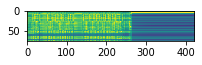

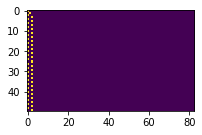

Count 808 | 오전 9시에 영업하시나요 ? _ => <s>오ㅏㄹㅇ싱영업하히나요?</s> => 안  9시에 영업업나나요?   


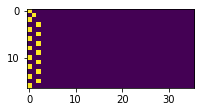

09-26 07:59:52
Mean Train Loss: 0.025657276864180997
Mean Train Seq2Seq Loss: 1.8797808023019138
Train CER: 0.5743292479499921
Eval Count 50 | 3월18일 오후5시 예약 가능한가요?  => <s>다뫄시바에 오 *시 예약 가능한가요?</s> => 안녕하세요 10에 예약약가가능가가가요?


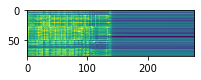

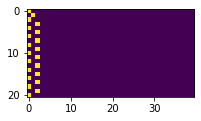

Eval Count 64 | 방금 배달했는데 스테이크에서 바퀴벌레가 나왔어요 ____ => <s>단문달자했는데 ㅅ테이카조 버기부려하하 핬어요.</s> => 안장포장하 데는데  계백계  서      서 화화화화화화


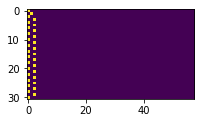

09-26 08:00:15
Mean Evaluation Loss: 0.02790051533712904
Mean Evaluation Seq2Seq Loss: 2.421046133254334
Evaluation CER: 0.593661100803958


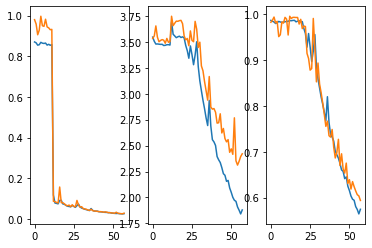

-------------------------------------------------------------------------------------------------------
09-26 08:00:15
Count 200 | 지금 행사하고 있는게 있나요? ______ => <s>지금 만 사그인에 있나요?</s> => 지금 가   할   있나요?        


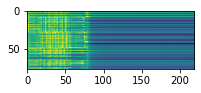

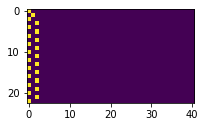

Count 400 | 영업시간 한시간 전에 가도 식사할 수 있나요? ____ => <s>영업시간한시간저에가도 식사ㅏ할 수 있나요?</s> => 영업시간 한시간 전에    식사할 수 있나요?     


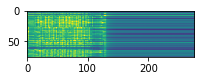

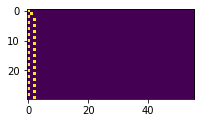

Count 600 | 몇 시까지 런치 타임이에요? _ => <s>몇 시까지 어지타임애요?</s> => 몇 시까지 런치 타임이요요?  


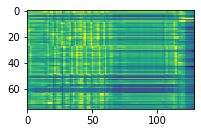

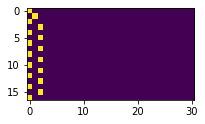

Count 800 | 안내하는 분이랑 통화 가능한가요? ____ => <s>다니하이그예아 포가 가능한가요?</s> => 아이 할웃        가능한가요?    


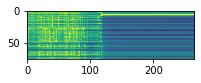

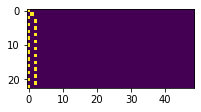

Count 808 | skt 할인 행사는 포인트가 남아있어야만 가능한건가요? 자세하게 알 수 있을까요? ____ => <s>*스기알는 사는 고인트가 나아이 스할 밚는건거아요 안자 하ㅣ 알 수 있을까요?</s> => sk      는   는                         까 까요까 ?     


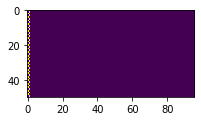

09-26 08:08:58
Mean Train Loss: 0.02397030742548853
Mean Train Seq2Seq Loss: 1.8113485244690373
Train CER: 0.5556582269334274
Eval Count 50 | 신정에도 영업하나요? ___ => <s>순성에도 영업 하나요?</s> => 추석에도 영업  나나요?  


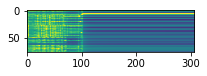

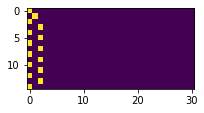

Eval Count 64 | 런치 메뉴 몇 시까지 주문 가능해요? _ => <s>런치메뉸 몇시까지 주문 가능해요?</s> => 런치 메뉴 몇 시까지 주문 가가요요?  


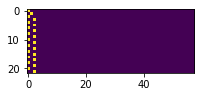

09-26 08:09:21
Mean Evaluation Loss: 0.024600899796207863
Mean Evaluation Seq2Seq Loss: 2.3255568848772397
Evaluation CER: 0.5935573974557489


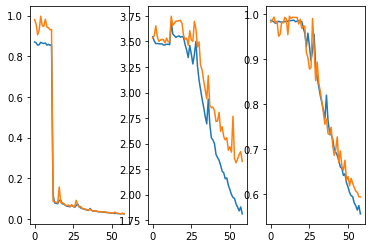

-------------------------------------------------------------------------------------------------------
09-26 08:09:21
Count 200 | 주차 도와 주시는 분 계신가요? _ => <s>주차고 하즈시는 분제인가요?</s> => 주차     는   제인가요?   


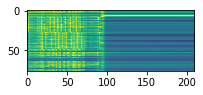

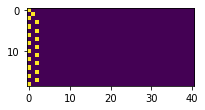

Count 400 | 다른 할인이랑  중복으로 할인받을 수 있나요? ____ => <s>잘렐가이애아 중보오로하은 받일 수 있나요?</s> => 메일       로  로 로 받을 수 있나요?     


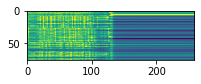

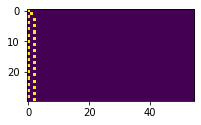

Count 600 | 봉고차 1대 주차 가능한가요?  => <s>람버차하데 주차 가능한가요?</s> => 얼마     주차 차가능가한가요


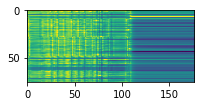

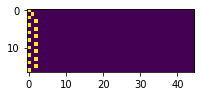

Count 800 | 생일 잔치 예약하려는데 가능한가요? ___ => <s>새일 *체 예약하렸는데 가능한가요?</s> => 생일  생 예약하려는데 가가한가요??   


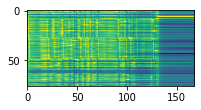

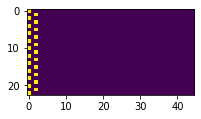

Count 808 | 안녕하세요 영업시간 관련해서 문의드립니다 주말에는 몇 시에 오픈하시나요? ______ => <s>안녕하세요 영엇앙거려엘더부이드립니다 주마에는 몇 시엥 오픈마시나요?</s> => 안녕하세요 마번시에  문에     에    말에  업시시에  픈오픈하요요       


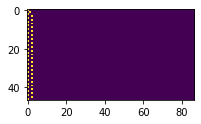

09-26 08:18:00
Mean Train Loss: 0.022762310651582386
Mean Train Seq2Seq Loss: 1.7554413194830294
Train CER: 0.5429196990526218
Eval Count 50 | 웨이팅 얼마나 걸리나요? _ => <s>멩ㅌ 얼마나 멀리나요?</s> => 요   마얼마마마나리요요  


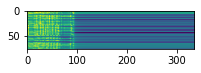

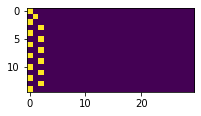

Eval Count 64 | 10일 점심시간 6명 자리 있나요? ___ => <s>지그 덩잉시간ㄴ 며명 타있나요?</s> => 지금     간       있나요?    


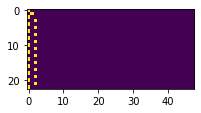

09-26 08:18:22
Mean Evaluation Loss: 0.02419466581348992
Mean Evaluation Seq2Seq Loss: 2.2844667307185746
Evaluation CER: 0.5820314874475716


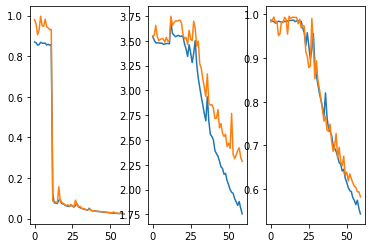

-------------------------------------------------------------------------------------------------------
09-26 08:18:22
Count 200 | 단체로 가려고 하는데 할인 받을 수 있나요? __ => <s>다처로가려고 하는데 하이앋블 수 인가요?</s> => 단체로 가 려고 는데      받   있요??  


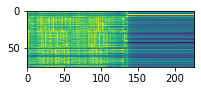

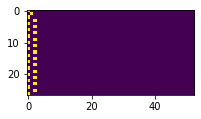

Count 400 | 예약 하려고 하는데요 __ => <s>예ㅖ약하려고 하는데요.</s> => 예약 하려고 하는데요   


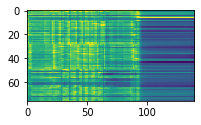

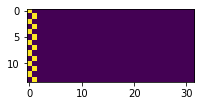

Count 600 | 브레이크 타임은 몇시부터 몇시까지에요? _ => <s>브ㅔ레이크 타임은 믈시부터뎣 시까지ㅐ요?</s> => 브레이크 타임이 런치 시 몇부터 지요?? 


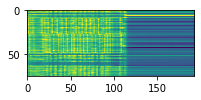

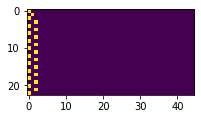

Count 800 | 네 그런데 예약시간이 좀 변경될꺼 같아서요 혹시 몇시간 전에 전화하면 될까요? ______ => <s>내 ㅡ레에 예약 하아이소편면 델꽁 같아수요 호ㅗ이 대자갈좀여 처 하드 될까요.</s> => 네 네월  예약 해해            요     될   될     요 요        


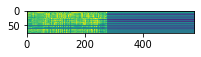

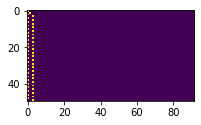

Count 808 | 전 메뉴 배달 가능한가요? __ => <s>저이ㅣ 배당 가능한가요?</s> => 당일 배달 가가능한가요?    


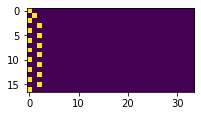

09-26 08:26:59
Mean Train Loss: 0.022396905261035945
Mean Train Seq2Seq Loss: 1.7223889507373114
Train CER: 0.5356862900091562
Eval Count 50 | 2살 아기가 있는데 자리에 아기의자 주실 수 있나요?  => <s>주사가리가 있는데 다리 아지자ㅏㄹ 술ㅆ 수 있나요?</s> => 돌차타자 가 있는데  리  자              


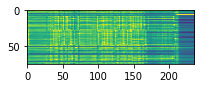

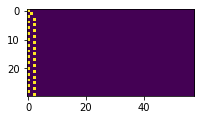

Eval Count 64 | 크리스마스날 영업하나요? ____ => <s>스리스마시알잉옵 하나요?</s> => 크리스마스  영업 하나요요    


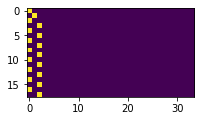

09-26 08:27:21
Mean Evaluation Loss: 0.023526439939836503
Mean Evaluation Seq2Seq Loss: 2.2600445925114268
Evaluation CER: 0.5850980628083263


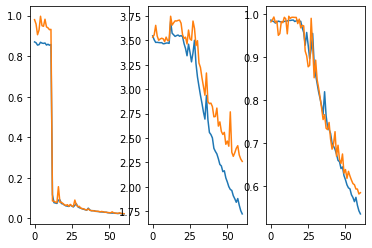

-------------------------------------------------------------------------------------------------------
09-26 08:27:21
Count 200 | 각 매장마다 기저귀 갈수 있는 시설이 있나요? __ => <s>강게당 마가요 지저ㅣ갈수있는 시사 있나요?</s> => 현기   갈     수수     있있나요?     


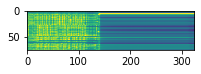

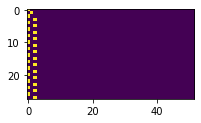

Count 400 | 지금 식사 가능한가요 ? _ => <s>지그시 가능한가요?</s> => 지금 식사 가능한가요?   


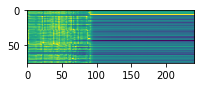

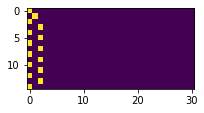

Count 600 | 혹시 창가쪽 자리 예약 가능 할까요 ___ => <s>혹시 차가족자리 예약 가능할까요?</s> => 혹시 창가자리자리 예약 가능까요요요? ? 


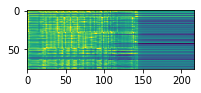

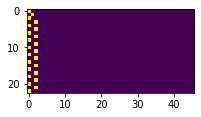

Count 800 | 금요일 저녁에 동창회 잡으려고 하는데 2층에 25명 정도 예약 받을 수 있나요? ____ => <s>앰묘일 ㅈ녁에에 돈차이 자오겨고 하는데 이칭요ㅔㄹ 주믈 *ㅏ명정동 예약 앋을 숭 있나요?</s> => 모임모12 에 에 지 잡 잡고 는데데 2 2 2 2525 로     을 수 있나요?   


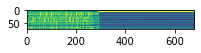

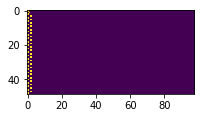

Count 808 | 할인카드는 무엇있나요? ____ => <s>할인카드는 모엇이 있나요?</s> => 할인카드는 무엇있 있나요    


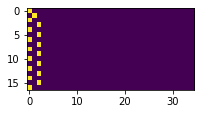

09-26 08:35:57
Mean Train Loss: 0.02195856959305871
Mean Train Seq2Seq Loss: 1.6976946464516054
Train CER: 0.5308966455321296
Eval Count 50 | 번호좀 확인할게요 _____ => <s>건노좀 하지 핼게요.</s> => 오제  현픽화해  요요요요 


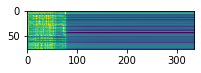

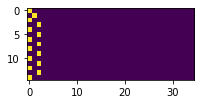

Eval Count 64 | 멤버십 할인과 생일 할인을 같이 쓸 수 있어요? ____ => <s>메버 시타인거ㅏ생이 할인으 밭이 쓸 수 있어요?</s> => 멤버십 할인  이할  이  이               


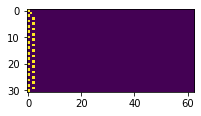

09-26 08:36:20
Mean Evaluation Loss: 0.02339392312846658
Mean Evaluation Seq2Seq Loss: 2.2587675506947478
Evaluation CER: 0.5769526327114007


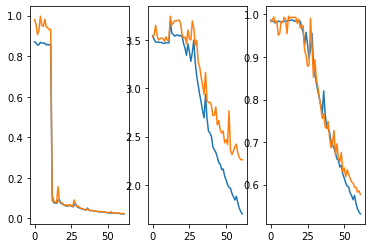

-------------------------------------------------------------------------------------------------------
09-26 08:36:20
Count 200 | 이전에 예약을 했는데요 변경 가능할까요? ___ => <s>이저으이야으에섰년데요 졍졍 가능할까요?</s> => 이터넷 예약 는 데      가능할까요?    


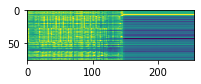

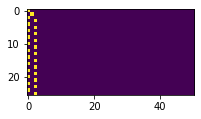

Count 400 | 에이드는 무슨 과일들이 있어요? ____ => <s>네이든는 모소고안 되리 있어요?</s> => 네일 는         어계요요?    


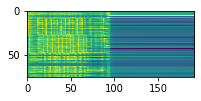

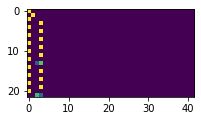

Count 600 | 지금 전화예약 가능한가요? __ => <s>지금 전장 예약 가능한가요?</s> => 지금 전화 예약 가능한가요?  


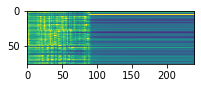

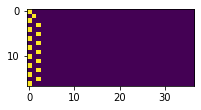

Count 800 | 네 그 골드 코스트 코코넛 쉬림프 2개를 취소하고 기브미 파이브 2개로 바꿀 수 있나요?  => <s>네ㅣ 근이 컨트커스크커곤허 시긴트 그게로지서하ㅏ고이본이 파히포오 *ㅗ재이 건졍할 수있나요.</s> => 네  태   코스트 코코넛  2          코 코      할   할 있 있     


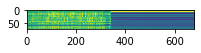

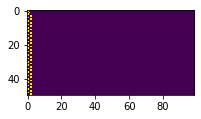

Count 808 | 여기는 영업쉬는날이 어떻게 되죠~? ___ => <s>러기느 영업시은눈이 어떻게 되죠?</s> => 거기 영업업시간 이 어떻게 되죠죠     


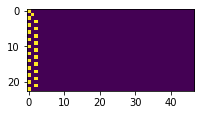

09-26 08:45:03
Mean Train Loss: 0.0218216689966578
Mean Train Seq2Seq Loss: 1.6923072911977761
Train CER: 0.5283180063702918
Eval Count 50 | 당일예약 가능 한가요? __ => <s>다리 예약 가능한가요?</s> => 당일 예약 가능한가요?   


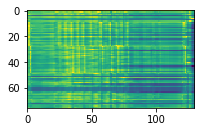

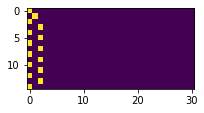

Eval Count 64 | 에이드는 무슨 과일들이 있어요? ____ => <s>에ㅣ드는 몿서ㅗ갈들리 있나요?</s> => 대g는 동      어   있나요?   


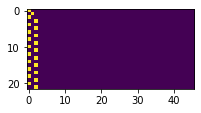

09-26 08:45:26
Mean Evaluation Loss: 0.023394152326550014
Mean Evaluation Seq2Seq Loss: 2.2815143706946897
Evaluation CER: 0.5622220205137515


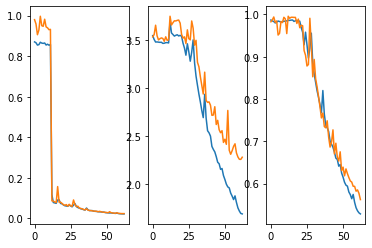

-------------------------------------------------------------------------------------------------------
09-26 08:45:27
Count 200 | 설날 당일에도 영업하나요? _____ => <s>설랑 바인에도 영업하나요?</s> => 설날 당일에도 영업하나요?      


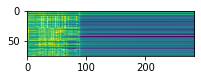

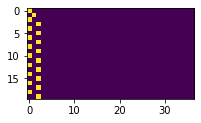

Count 400 | 생일쿠폰과 통신사 할인 같이 받을 수 있나요? ___ => <s>생일 우퐁와아 동신사 할인 밭시 받을 수 있나요?</s> => 생일 쿠폰과 통신사사할인이 같이  쓸 있나요? ?  


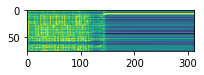

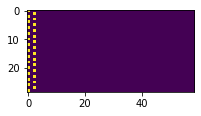

Count 600 | 몇시부터 먹을 수 있나요? ___ => <s>몇시부터ㅓ 머얼 수인가요?</s> => 몇시부부터      가요?    


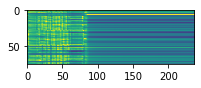

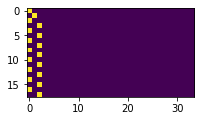

Count 800 | 아 그럼 혹시 거기 주차는 어디에 해요?  => <s>가그어혹시거기 주터 어에ㅔ요?</s> => 아 그렇 혹시         어에요    


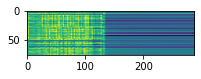

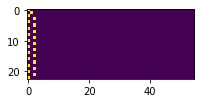

Count 808 | 죄송한데  멤버십 카드를 분실했는데 주민번호로 멤버십 번호 조회 가능한지요? _______ => <s>제다으가이되나스타드이드 수애인ㄷ시기가으르멤버시토드 드 가능핮세요</s> => 제가 할   버  를 를                         요 요         


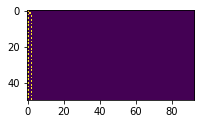

09-26 08:54:12
Mean Train Loss: 0.021177278415658637
Mean Train Seq2Seq Loss: 1.6340874881082894
Train CER: 0.5157098326024819
Eval Count 50 | 주말 저녁에 예약 꼭 해야되나요? ___ => <s>주말 ㅈ녁엥 예약고 기얀되나요?</s> => 주말 저녁에 예약하       나요?  


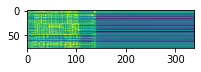

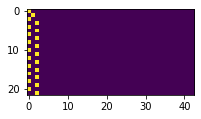

Eval Count 64 | 단체 예약 할 수 있나요? __ => <s>단체 ㅇ약할 수 있나요?</s> => 단체  약약 수수 있나요?   


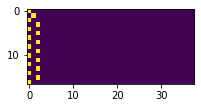

09-26 08:54:34
Mean Evaluation Loss: 0.023953705155912504
Mean Evaluation Seq2Seq Loss: 2.2968836525633813
Evaluation CER: 0.5700185258298661


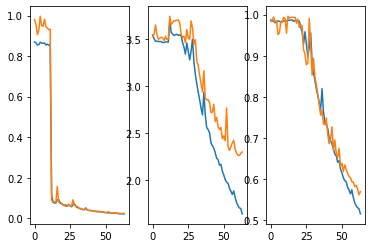

-------------------------------------------------------------------------------------------------------
09-26 08:54:34
Count 200 | 운전해서 가는데 연세대앞에서 어떻게 가나요? __ => <s>운자 에고 가는데언베다 구서 어떻게 되나요?</s> => 차천 가가가는데 데데   떻떻   가 되나?   


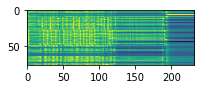

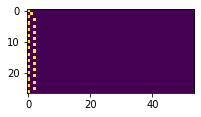

Count 400 | 여기 혹시 배달도 되나요?  => <s>크기혹시 배달도 되나요?</s> => 기기식지 배달도 되나요?  


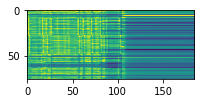

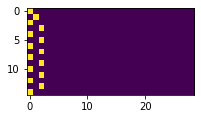

Count 600 | 금요일 12시에 예약할 수 있을까요? __ => <s>그용ㄹ **시이옉할 수있슬까요?</s> => 금요일 11시1 예약할 수 있 요?요   


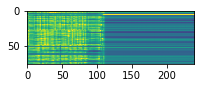

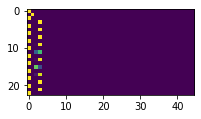

Count 800 | skt 할인 행사는 포인트가 남아있어야만 가능한건가요? 자세하게 알 수 있을까요? ____ => <s>*기가는 사른 고이트가 마마 있 숭알 밚늘건가아요 단자 하이 알 수 있을까요?</s> => 애기가                    가       코     수 있  있 ?요까 ? 


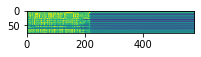

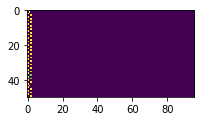

Count 808 | 언제부터예약가능한가요? ____ => <s>언제부터예약 가능한가요?</s> => 언제부터예 가능한가요?     


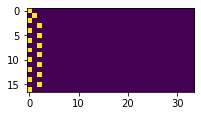

09-26 09:03:10
Mean Train Loss: 0.021014855595322398
Mean Train Seq2Seq Loss: 1.6182988188582133
Train CER: 0.5114084262717689
Eval Count 50 | 지금 이벤트 할인 중인 메뉴가 무엇이 있나요? ____ => <s>지금 이단다 할인져ㅡㄴ 메뉴가머 ㅓ 시나요?</s> => 지금 할인이 사     메뉴     요요?       


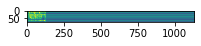

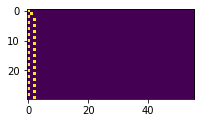

Eval Count 64 | 미리 메뉴 주문 해도 되나요?  => <s>미리 메뉴문매더외나요?</s> => 미리 메뉴  뉴   되나요?  


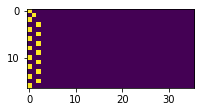

09-26 09:03:32
Mean Evaluation Loss: 0.022800516125832615
Mean Evaluation Seq2Seq Loss: 2.2621980287441943
Evaluation CER: 0.5720750618475834


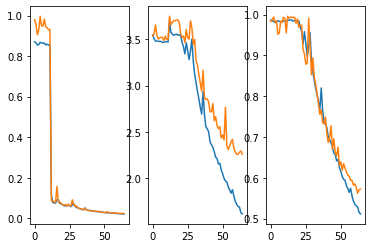

-------------------------------------------------------------------------------------------------------
09-26 09:03:32
Count 200 | 쿠폰 유효기간이 하루 지났는데 이거 못 쓰나요?  => <s>ㅂㅍ조 ㅇ랄리ㅏ골 시하르ㅡㄴ데에인므 도 딨나요?</s> => 서모       는데        있나요?    


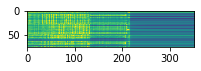

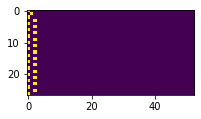

Count 400 | 예약방법 알려주세요 ____ => <s>예약 반머 알려주세요.</s> => 예약 법 알려주세요     


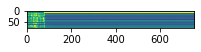

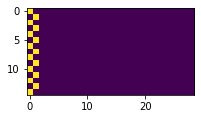

Count 600 | 점심 시간에 맞춰서 배달 가능할까요? ___ => <s>점심시간에ㅏ처소 배랄 가능할까요?</s> => 점심시간에에       가할할까요?     


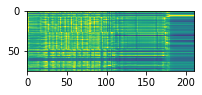

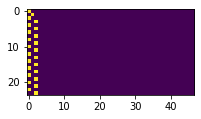

Count 800 | 블랙 라벨 스테이크 메뉴에서 패밀리 세트 가격이 제일 저렴한메뉴는 얼마일까요? ______ => <s>그름바넬 스테이크 메뉴해서 해ㅣ엫세테가 벽으제이 조명곤메뉴나 어 어모할까요?</s> => 런럼 찹스테이크 스세 백 세 해   스  메스메 메        게 좋 까요까요? 까 ? 


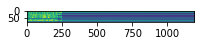

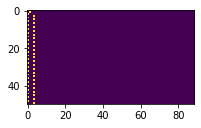

Count 808 | 전면주차 꼭 해야 되나요? ___ => <s>전나 주차 곡 시요 되나요?</s> => 전  주   워   나요??   


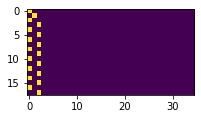

09-26 09:12:09
Mean Train Loss: 0.020399980484000116
Mean Train Seq2Seq Loss: 1.5823617885963657
Train CER: 0.5032107695751601
Eval Count 50 | 거기 주차하기 쉬운가요? _ => <s>거깅ㅇ 주차ㅏ깅 시이한가요?</s> => 거기 주주 주주차공가가요요?


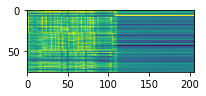

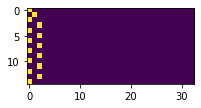

Eval Count 64 | 아는 건물이 아웃백 근처에 있는 지 궁금합니다 _______ => <s>아는건무링ㅇ웃백 근처에했는지 궁금합니다.</s> => 아웃백 근  웃백에 궁금궁금  있          합 합  


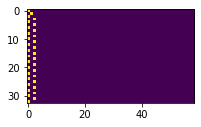

09-26 09:12:32
Mean Evaluation Loss: 0.022118414172414252
Mean Evaluation Seq2Seq Loss: 2.21454911487759
Evaluation CER: 0.5573885466853693


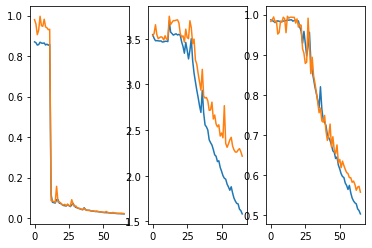

-------------------------------------------------------------------------------------------------------
09-26 09:12:32
Count 200 | 안녕하세요 뭐좀 여쭤보려고 전화 드렸습니다 ___ => <s>아녕하세요 며종겨전으여고 전하흐렸습니다.</s> => 안녕하세요 방문좀여쭤보려고 전화렸습니다 다    


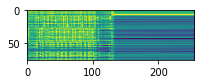

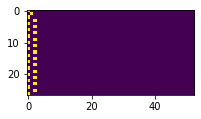

Count 400 | 처음 가는데 무엇을 시켜야 할까요? __ => <s>처가는데 뭐들 주차야할까요?</s> => 한 는는    주주차  가까요??    


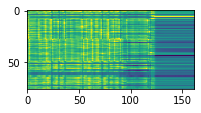

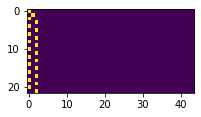

Count 600 | 마감 시간이 언제인가요? ____ => <s>다간 싱이 언제인가요?</s> => 다음 시간  제 인가요요?    


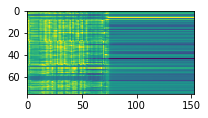

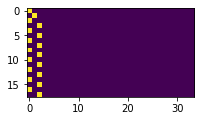

Count 800 | 스테이크와 샐러드 음료 주문 할께요 얼마인가요? 현대카드 있는데 할인 되나요? ______ => <s>세데이쿠 하샐마드 며 주문헤데요 얼마이가요 정메 카드 있는데 할인되나요?</s> => 제테이크 카 드  문   문                     할 할  되요? ?    


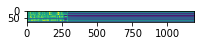

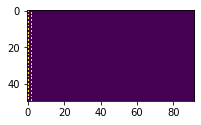

Count 808 | 요즘 가장 인기있는 메뉴는 뭐에요? ____ => <s>이지 바사은지있는 메뉴느 뭐어ㅔ요?</s> => 요즘 사사  쉬는는 메뉴는 뭐에요?     


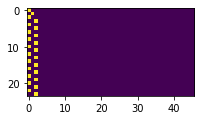

09-26 09:21:12
Mean Train Loss: 0.020117529820789935
Mean Train Seq2Seq Loss: 1.5608418477879369
Train CER: 0.49780183655131605
Eval Count 50 | 혹시 아이들을 위한 사탕을 별도로 판매하나요? __ => <s>혹시 할을 이약 사가는데도ㅗ 반겨하나요?</s> => 혹시 생일 예약           오나요?     


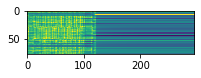

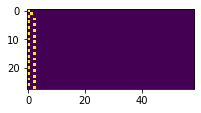

Eval Count 64 | 어떤 메뉴를 현재 판매중인가요? ______ => <s>어턴메뉴르안데 팓으주있나요?</s> => 어르 들   는       있나요?     


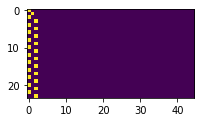

09-26 09:21:34
Mean Evaluation Loss: 0.021853770075575492
Mean Evaluation Seq2Seq Loss: 2.2143646877562366
Evaluation CER: 0.5521513173797438


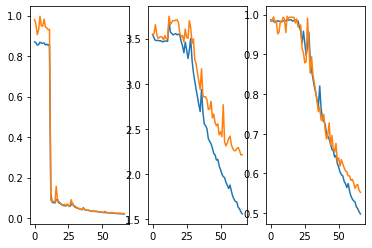

-------------------------------------------------------------------------------------------------------
09-26 09:21:35
Count 200 | 최대 몇시간까지 주차 가능해요?  => <s>새며슬려가 주차 가능해요?</s> => 새0 마지 주차  가능가능해?? 


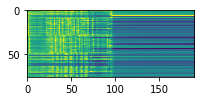

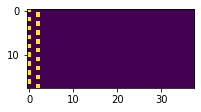

Count 400 | 그럼 도시락 메뉴로 7시까지 5인분 부탁드립니다 _ => <s>그룸ㅍ상메뉴로 여ㅓ시까지 오이분 부탁드 립니다.</s> => 도럼 도메뉴메뉴  지 지지  지 부탁부탁드립니다 다


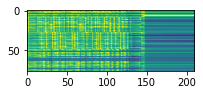

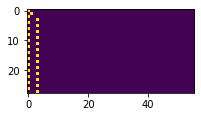

Count 600 | 아기와 함께 식사할수 있죠? _ => <s>아기에한테 식사핫 있ㅇㅈ요?</s> => 아기  사 사사사  있 죠?  


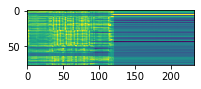

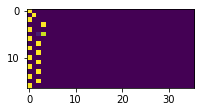

Count 800 | 요즘 할인혜택이나 이벤트뭐가 있나요 ___ => <s>이즈 칼이하트이하 이믄튼 무가있나요?</s> => 이즘 할인  인인벤트벤트가  나나나 ?  


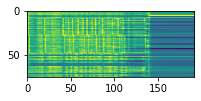

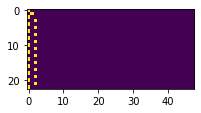

Count 808 | 아이가 먹을 수 있는 부드럽고 저자극적인 메뉴가 있으면 좋겠는데 혹시 있나요? ____ => <s>아여고ㅓ시믄트소포처사제리네는 벌씬지엥ㅆ는데 호시 있나요?</s> => 여러    트   를 를                       있 요나요?      


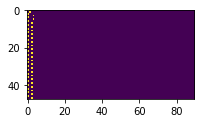

09-26 09:30:13
Mean Train Loss: 0.01980072736970996
Mean Train Seq2Seq Loss: 1.5401004589476837
Train CER: 0.4921096756187768
Eval Count 50 | 오늘 예약 가능할까요? __ => <s>우를 예약 가능할까요?</s> => 룸  예예 가가능할까요?  


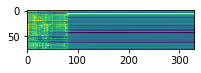

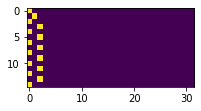

Eval Count 64 | 오늘 오픈하는 시간이 언제인가요? ____ => <s>으오폰하는 시간이 언제 인가요?</s> => 오픈 닫는 픈간시간이 언제인가요?     


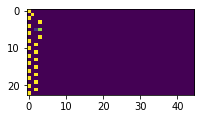

09-26 09:30:35
Mean Evaluation Loss: 0.02208059116067525
Mean Evaluation Seq2Seq Loss: 2.2300632652051036
Evaluation CER: 0.5594632254937598


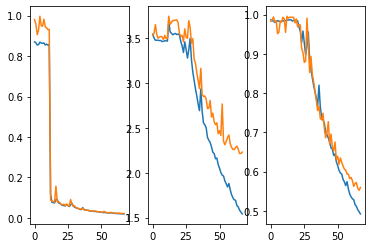

-------------------------------------------------------------------------------------------------------
09-26 09:30:35
Count 200 | 지인한테 전달받은 쿠폰도 사용가능한가요? ____ => <s>시아스 건달가응 수으데 하로 가능한가요?</s> => 식사가다        로   가능가능가요?    


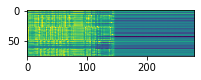

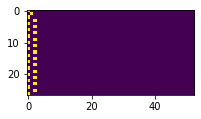

Count 400 | 그렇게 해주시면 감사하겠습니다 ____ => <s>그러케ㅐ 주시면 간사하겠습니다.</s> => 그렇게게 주시  감사사겠습니다     


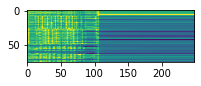

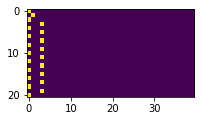

Count 600 | 주차비용 따로 내야 하나요? _ => <s>주차비용따로 내야 하나요?</s> => 주차비용 따로로 야야나나?   


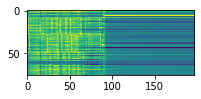

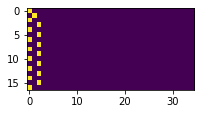

Count 800 | 오늘 저녁 6시 예약했는데 좀 늦을 것 같네요 저녁 7시로 변경할 수 있나요? ______ => <s>오느 저여*ㅣ시 예약했는데 그빈츠서 하데요 전ㅇㄱㅅ시곤 바사할 수 있나요?</s> => 목늘 오전에예예약예예약했는 취소했                  수 있나요?        


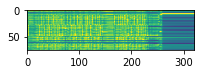

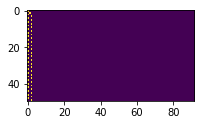

Count 808 | 멤버쉽포인트 사용을 할 수 있나요? ___ => <s>앰버십쿤트 하요오혈 수 있나요?</s> => 멤버쉽쿠폰      쓸 수 있나요나요?  


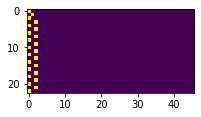

09-26 09:39:20
Mean Train Loss: 0.01952831645295045
Mean Train Seq2Seq Loss: 1.5195071938839144
Train CER: 0.48716174205724105
Eval Count 50 | 4시도 런치로 들어가나요?  => <s>*시브 온치븜 브영하나요?</s> => 12월 2 지 픈 하나나? 


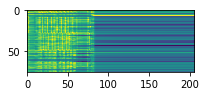

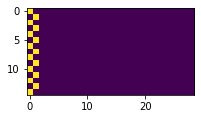

Eval Count 64 | 유모차 들고 들어갈 수 있을까요? _ => <s>이ㅜ처 질고 드어할 수 있을까요?</s> => 위번        갈  수 있을까요?


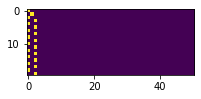

09-26 09:39:44
Mean Evaluation Loss: 0.021486376563588823
Mean Evaluation Seq2Seq Loss: 2.220223692437001
Evaluation CER: 0.5558239236761066


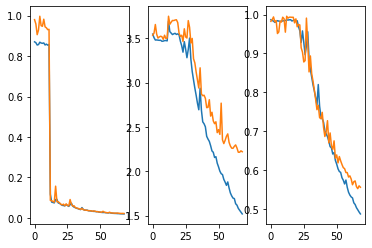

-------------------------------------------------------------------------------------------------------
09-26 09:39:44
Count 200 | 주류는 있는지요? ___ => <s>훌여가 미룐지요.</s> => 새분는 자리 요요    


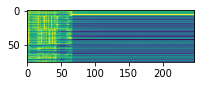

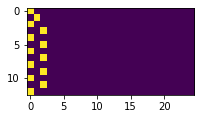

Count 400 | 사람이 좀 많은데 단체석 있어요? ___ => <s>사라이 종말인데 단체소 있어요?</s> => 사람  좀단 단데 단  있어요?     


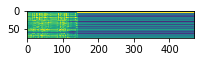

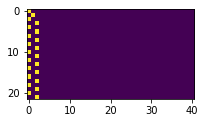

Count 600 | 네 안녕하세요 투움바파스타 방문포장예약하려고 하는데요 ___ => <s>네 ㄴ녀하세요 소바차스타 방문포정 예약하려고 하는데요.</s> => 네 안녕하세요 투투   방문포 장 예 하려하하데요 요    


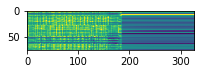

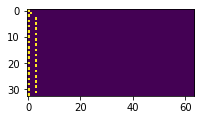

Count 800 | 예약 좀 잡아주시겠어요? ___ => <s>예약 좀 앋까주시맀어요?</s> => 예약 좀 잡아주시겠어요?    


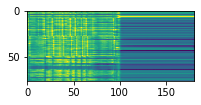

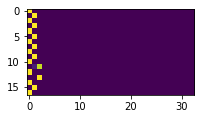

Count 808 | 오픈 시간과 마감시간을 알려주세요 ____ => <s>옾ㄴ시간건 바끔시간이 알리주세요?</s> => 오픈시간이랑 감시간까    주주요     


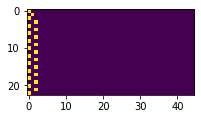

09-26 09:48:36
Mean Train Loss: 0.019140036971544018
Mean Train Seq2Seq Loss: 1.4989615996939707
Train CER: 0.48337314869554326
Eval Count 50 | 주차비는 얼마인가요? ___ => <s>주차비느얼나인가요?</s> => 주차비엘목에 얼마인가요?  


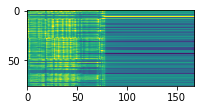

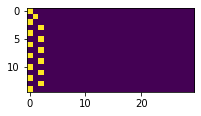

Eval Count 64 | 만차여서 주차 할데가 없는데 근처  무료주차장있나요? _ => <s>만챃조 주챃이가 ㄱ 었는데 근처그주차장있나요?</s> => 만차일 3차차 그    는  근에            근


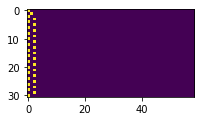

09-26 09:48:58
Mean Evaluation Loss: 0.021567961176286787
Mean Evaluation Seq2Seq Loss: 2.147064719864783
Evaluation CER: 0.5420308522709848


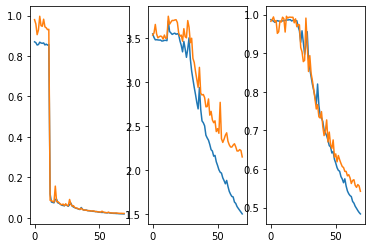

-------------------------------------------------------------------------------------------------------
09-26 09:48:59
Count 200 | 창가자리를 예약하고 싶어요 ____ => <s>창가 가리으 예약하고 싶어요.</s> => 창가  리   하고 싶어요     


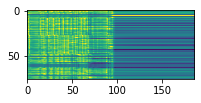

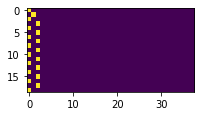

Count 400 | 그럼 베이비 폭립 하나와 스파게티 종류가 뭐 있죠? _ => <s>글 베 버스복 부주ㅏ라 다리지 저ㅏㅇ모죠?</s> => 그럼 그버스 스  랑   장  발 발거꺼거든죠?    


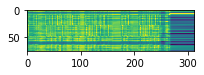

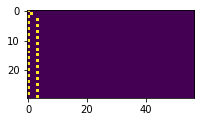

Count 600 | 단체 예약도 가능한가요? ___ => <s>단체 예약도 가능한가요?</s> => 단체 예약도 가능한가요?    


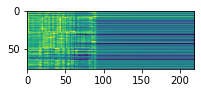

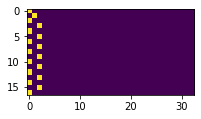

Count 800 | 지금 가면 몇분 정도 기다려야 해요? __ => <s>지금가면 몇분정더저가대하세요?</s> => 지금 면면 몇분 정    해주 요 ?   


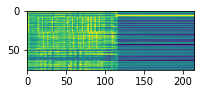

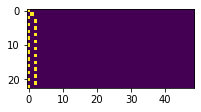

Count 808 | 안녕하세요 이번주 일요일에 저희 아이가 생일인데 생일 파티 예약가능한가요? ________ => <s>아녀하세요 이언주일으이ㅔ 정하노성이은데 세ㅔ이타태 예약 가능ㅎㄴ가요?</s> => 안녕하세요 이번주 토 일에 일   일     데 일 서    예예예약가가가한가한 ?    


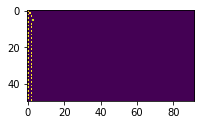

09-26 09:57:40
Mean Train Loss: 0.01963250715803287
Mean Train Seq2Seq Loss: 1.5084049496861343
Train CER: 0.4849283471610742
Eval Count 50 | 현금 할인도 있나요? ___ => <s>항그 할인도 있나요?</s> => 학생 할인  있나나??   


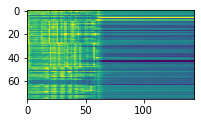

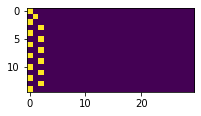

Eval Count 64 | 코스요리 말고 섞어서 시켜도 되나요? __ => <s>커태이이말도 사까바 ㅈ시텝되나요?</s> => 베지테이크           나나요?요? 


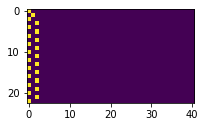

09-26 09:58:02
Mean Evaluation Loss: 0.02263664858215812
Mean Evaluation Seq2Seq Loss: 2.2208204601546693
Evaluation CER: 0.5581606964117808


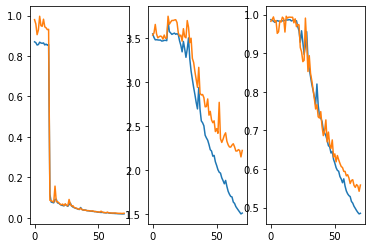

-------------------------------------------------------------------------------------------------------
09-26 09:58:03
Count 200 | 대학생도 학생 할인 되나요? ___ => <s>지하시도ㅗ 학새할인 되나요?</s> => 생학생도 학생인할  되나요요    


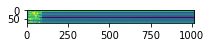

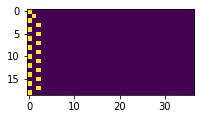

Count 400 | 예약 수요일 같은시간으로 변경하려고 하는데요 ____ => <s>예요 슬 가은 주만으 곤겨가려고 하느 ㄴ데요.</s> => 예요  요   주  으   하려고 고 하는데요    


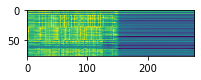

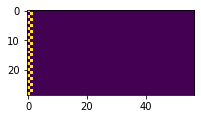

Count 600 | 다시 한번 말해주시겠어요? __ => <s>다시가모 마룰 수게서요?</s> => 다시시 번 말해주실래요?    


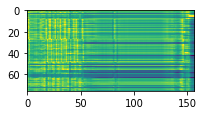

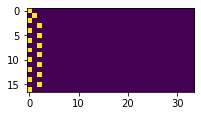

Count 800 | 생일 쿠폰 날짜 지났는데 사용되나요? ___ => <s>ㅈ일 쿠폰문 잔 시간ㅆ은데 찰용 되나요?</s> => 일일 쿠폰 중인  났데    되되요요?   


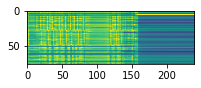

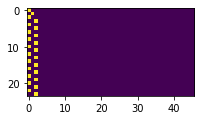

Count 808 | 위 모든 질문에 해당하지 않는 아웃백에 묻고 싶은 자유로운 질문을 해주세요 ________ => <s>으보은 주구엥가 가자하느가 엇백게고 싶은 자룐지무해주세요.</s> => 위 모든 질문에 가능한가       묻 묻             주주세주세요세       


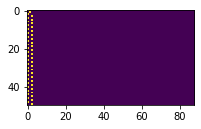

09-26 10:06:41
Mean Train Loss: 0.021287746181800234
Mean Train Seq2Seq Loss: 1.5847685084799492
Train CER: 0.5000351351826151
Eval Count 50 | 오늘 예약가능한가요? ___ => <s>오늘 예약 가능한가요?</s> => 오늘 예약 가능한가요?   


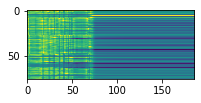

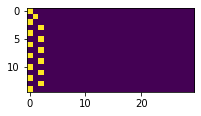

Eval Count 64 | 혹시 이번달에 쉬는날이 있나요 ? __ => <s>호시이가타에 시은날이 있나요?</s> => 혹시 아번달에    는날이이 있나요? 


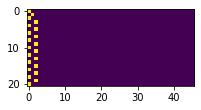

09-26 10:07:03
Mean Evaluation Loss: 0.022692076552974616
Mean Evaluation Seq2Seq Loss: 2.2729758098443607
Evaluation CER: 0.5485265225933202


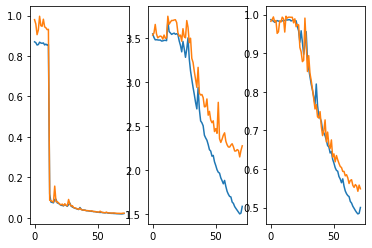

-------------------------------------------------------------------------------------------------------


In [26]:
EPOCH = 6 * 10
           
# net = Mel2SeqNet(80, 512, 256)


# net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut'
# net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024'

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

net = Mel2SeqNet(80, 512, 256, len(unicode_jamo_list), device)
net_optimizer = optim.Adam(net.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss().to(device)

# try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
# except:
#     print('Failed to load model')

keyword = 'NSML_jamo_seq2seq_from_scratch_3'

jamo2char_net = Seq2SeqNet(256, jamo_tokens, char2index, device)
jamo2char_optimizer = optim.Adam(jamo2char_net.parameters(), lr=0.001)
seq2seq_criterion = nn.NLLLoss(reduction='none').to(device)

train_loss_history = list()
eval_loss_history = list()

train_seq2seq_loss_history = list()
eval_seq2seq_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history_{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history_{}.npy'.format(keyword)))
except:
    print("No CER Record")
    
try:
    load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    train_seq2seq_loss_history = list(np.load('model_saved/train_seq_loss_history_{}.npy'.format(keyword)))
    eval_seq2seq_loss_history = list(np.load('model_saved/eval_seq_loss_history_{}.npy'.format(keyword)))
except:
    print('No Seq2Seq Loss Record')
    
try:
#     load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Loss History Error".format(keyword))

# keyword = 'NSML_pure_jamo_50ms_pad_cut_1024_copy'

min_loss_net = 1e+10
min_loss_seq = 1e+10

for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    
    try:
        load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    except:
        print('Could not found model_saved/{}'.format(keyword))
        
    try:
        load(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    except:
        print('Could not found model_saved/seq_{}'.format(keyword))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()
    seq2seq_loss_list_train = list()

    total_dist = 0
    total_length = 0
    count = 0
    net.train()
    jamo2char_net.train()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
            lev_input = ground_truth
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            
            lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)

            
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_train(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), jamo2char_optimizer, seq2seq_criterion)
            
            seq2seq_loss_list_train.append(seq2seq_loss)
        
            pred_string_list = Decode_Lev(lev_pred, index2char)
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            dist, length = char_distance_list(true_string_list, pred_string_list)
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 200 == 0:
                print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions[0].detach().cpu().numpy().T)
                plt.show()
        
    print("Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
    plt.figure(figsize = (3, 3))
    plt.imshow(attentions[0].detach().cpu().numpy().T)
    plt.show()

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    train_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_train))
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Mean Train Seq2Seq Loss: {}".format(train_seq2seq_loss))
    print("Train CER: {}".format(train_cer))
    
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    train_seq2seq_loss_history.append(train_seq2seq_loss)
    
    ###########################################################
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()
    seq2seq_loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    net.eval()
    jamo2char_net.eval()
    
    count = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth, lev_truth_loss_mask = batch
            pred_tensor, loss = evaluate(net, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            jamo_result = Decode_Prediction_No_Filtering(pred_tensor, tokenizer)
            
#             lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
            lev_input = ground_truth
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
        
            lev_input = Decode_Jamo_Prediction_And_Batch(pred_tensor)
            lev_pred, attentions, seq2seq_loss = jamo2char_net.net_eval(lev_input.to(device), lev_truth.to(device), lev_truth_loss_mask.to(device), seq2seq_criterion)
            seq2seq_loss_list_eval.append(seq2seq_loss) ###############
        
            pred_string_list = Decode_Lev(lev_pred, index2char)
            true_string_list = Decode_Lev_Truth(lev_truth.detach().cpu().numpy(), index2char)
            dist, length = char_distance_list(true_string_list, pred_string_list)
            
            total_dist += dist
            total_length += length
            
            count += 1
            if count % 50 == 0:
                print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
                plt.figure(figsize = (3, 3))
                plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy().T)
                plt.show()
                
                plt.figure(figsize = (3, 3))
                plt.imshow(attentions[0].detach().cpu().numpy().T)
                plt.show()
            
    print("Eval Count {} | {} => {} => {}".format(count, true_string_list[0], jamo_result[0], pred_string_list[0]))
    plt.figure(figsize = (3, 3))
    plt.imshow(attentions[0].detach().cpu().numpy().T)
    plt.show()
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    
    eval_seq2seq_loss = np.mean(np.asarray(seq2seq_loss_list_eval)) ##############
    
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Mean Evaluation Seq2Seq Loss: {}".format(eval_seq2seq_loss)) ##################
    print("Evaluation CER: {}".format(eval_cer))
    
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    eval_seq2seq_loss_history.append(eval_seq2seq_loss) ##################
    
    #####
    
#     if min_loss_net > train_loss:
#         min_loss_net = train_loss

    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    
    if min_loss_seq > train_seq2seq_loss:
        min_loss_seq = train_seq2seq_loss
        save(jamo2char_net, jamo2char_optimizer, 'model_saved/seq_{}'.format(keyword))
    
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    
    np.save('model_saved/train_seq_loss_history_{}'.format(keyword), train_seq2seq_loss_history)
    np.save('model_saved/eval_seq_loss_history_{}'.format(keyword), eval_seq2seq_loss_history)
    
    np.save('model_saved/train_cer_history_{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history_{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.subplot(131)
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)

    plt.subplot(132)
    plt.plot(train_seq2seq_loss_history)
    plt.plot(eval_seq2seq_loss_history)

    plt.subplot(133)
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    
    